<a href="https://colab.research.google.com/github/adetuire/credit-card-fraud/blob/main/Credit_Card_Fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
mlg_ulb_creditcardfraud_path = kagglehub.dataset_download('mlg-ulb/creditcardfraud')

print('Data source import complete.')


Using Colab cache for faster access to the 'creditcardfraud' dataset.
Data source import complete.


In [84]:
%%capture
%pip install -q --upgrade scikit-learn==1.4.2 imbalanced-learn==0.12.3 xgboost==2.1.1


In [85]:
import shap

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Credit Card Fraud Detection
## Pipeline Journey

**Goal.** Detect fraudulent transactions with calibrated probabilities and a cost-aligned decision threshold. Report imbalanced-learning metrics and business impact.

### 1) Data and Integrity
- Load credit card transactions; verify required columns (`Time`, `Amount`, `Class`, feature columns).
- Basic hygiene: dtype checks, duplicate checks, missing-value audit, sort by `Time` if modeling choices depend on order.

**Output:** clean DataFrame.

---

### 2) Exploratory Analysis (EDA)
- **Univariate:** histograms/boxplots to inspect skew, heavy tails, and outliers (notably `Amount`). Consider `log1p(Amount)` for analysis and plots.
- **Bivariate (by `Class`):** boxplots and KDEs per feature vs `Class` to gauge separability; read shifts in median/spread and tail mass.
- **Multivariate:** correlation heatmap to spot redundancy; optional PCA/t-SNE for structure sanity checks.

**Output:** feature notes that inform preprocessing and modeling.

---

### 3) Splits and Validation
- Define **train / validation / test** partitions as done above.
- Use the **validation** partition for hyperparameter selection, probability calibration, and threshold selection; reserve **test** strictly for final reporting.

**Output:** `(X_train, y_train)`, `(X_val, y_val)`, `(X_test, y_test)`.

---

### 4) Modeling
- Baselines and ensembles:
  - **Logistic Regression** (strong linear baseline).
  - **Random Forest** (non-linear).
  - **XGBoost** (gradient boosting).
- Imbalance handling: class weighting and/or resampling (as configured in the corresponding cells).
- Hyperparameters selected using validation performance.

**Output:** trained models with validation/test score predictions.

---

### 5) Probability Calibration
- Calibrate model scores to probabilities using **CalibratedClassifierCV** (isotonic or sigmoid).
- Verify with a **reliability (calibration) curve**.

**Output:** calibrated probabilities on validation and test for each model.

---

### 6) Metric Reporting (Model Quality)
- Primary: **PR-AUC** (appropriate for extreme imbalance).
- Secondary: **ROC-AUC**, precision/recall curves.
- Low-FPR operating characteristics: **recall at FPR = 0.1%, 0.5%, 1%**.

**Output:** metric tables/plots for each model.

---

### 7) Business-Cost Decision Rule
- Define costs: **C_FN** (missed fraud) and **C_FP** (unnecessary review).
- Choose operating threshold **τ\*** by **minimizing expected total cost on the validation set**.
- Lock **τ\*** and evaluate on the **test** set.

**Output:** per-model threshold, FP/FN/TP/TN, alert volume, total cost on test.

---

### 8) Sensitivity Analysis
- Re-evaluate the thresholding step under multiple cost scenarios (e.g., `C_FN/C_FP` pairs).
- Report how **τ\*** and alert volume change and whether model ranking shifts.
- Include **“cost multiple vs. oracle (same alerts)”** to contextualize performance relative to a perfect prioritization at the same alert count.

**Output:** sensitivity table and optional cost-curve plot on validation.

---

# Import Libraries

In [87]:
# libraries needed for data manipulation and visualization, and to remove warnings
import warnings, os, json, math, sys
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from IPython.display import display

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, auc,
    f1_score, precision_score, recall_score, confusion_matrix, brier_score_loss
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

from xgboost import XGBClassifier

warnings.filterwarnings("ignore")
sns.set_context("notebook")
plt.rcParams["figure.figsize"]=(10,5)

SEED = 42
np.random.seed(SEED)

# Business cost assumptions
COST_FP = 20.0     # investigation cost per false alert
COST_FN = 200.0   # average loss per missed fraud



## Load Data

In [88]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [89]:
train = df.copy()

In [90]:
train.shape

(284807, 31)

## Initial Data Exploration

In [91]:
train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [92]:
display(train.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

None

In [93]:
display(train.describe().T)


,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [94]:
print("Shape:", train.shape)


Shape: (284807, 31)


# Data Cleaning

In [95]:
print(train.columns.tolist())


['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


## Check missing values


In [96]:
print("Missing values:\n", train.isnull().sum())

Missing values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [97]:
# drop duplicate values in the data
print("Duplicates:", train.duplicated().sum())
train = train.drop_duplicates().reset_index(drop=True)

Duplicates: 1081


In [98]:
# number of unique values in each column
train.nunique()

,0
Time,124592
V1,275663
V2,275663
V3,275663
V4,275663
V5,275663
V6,275663
V7,275663
V8,275663
V9,275663


In [99]:
train.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


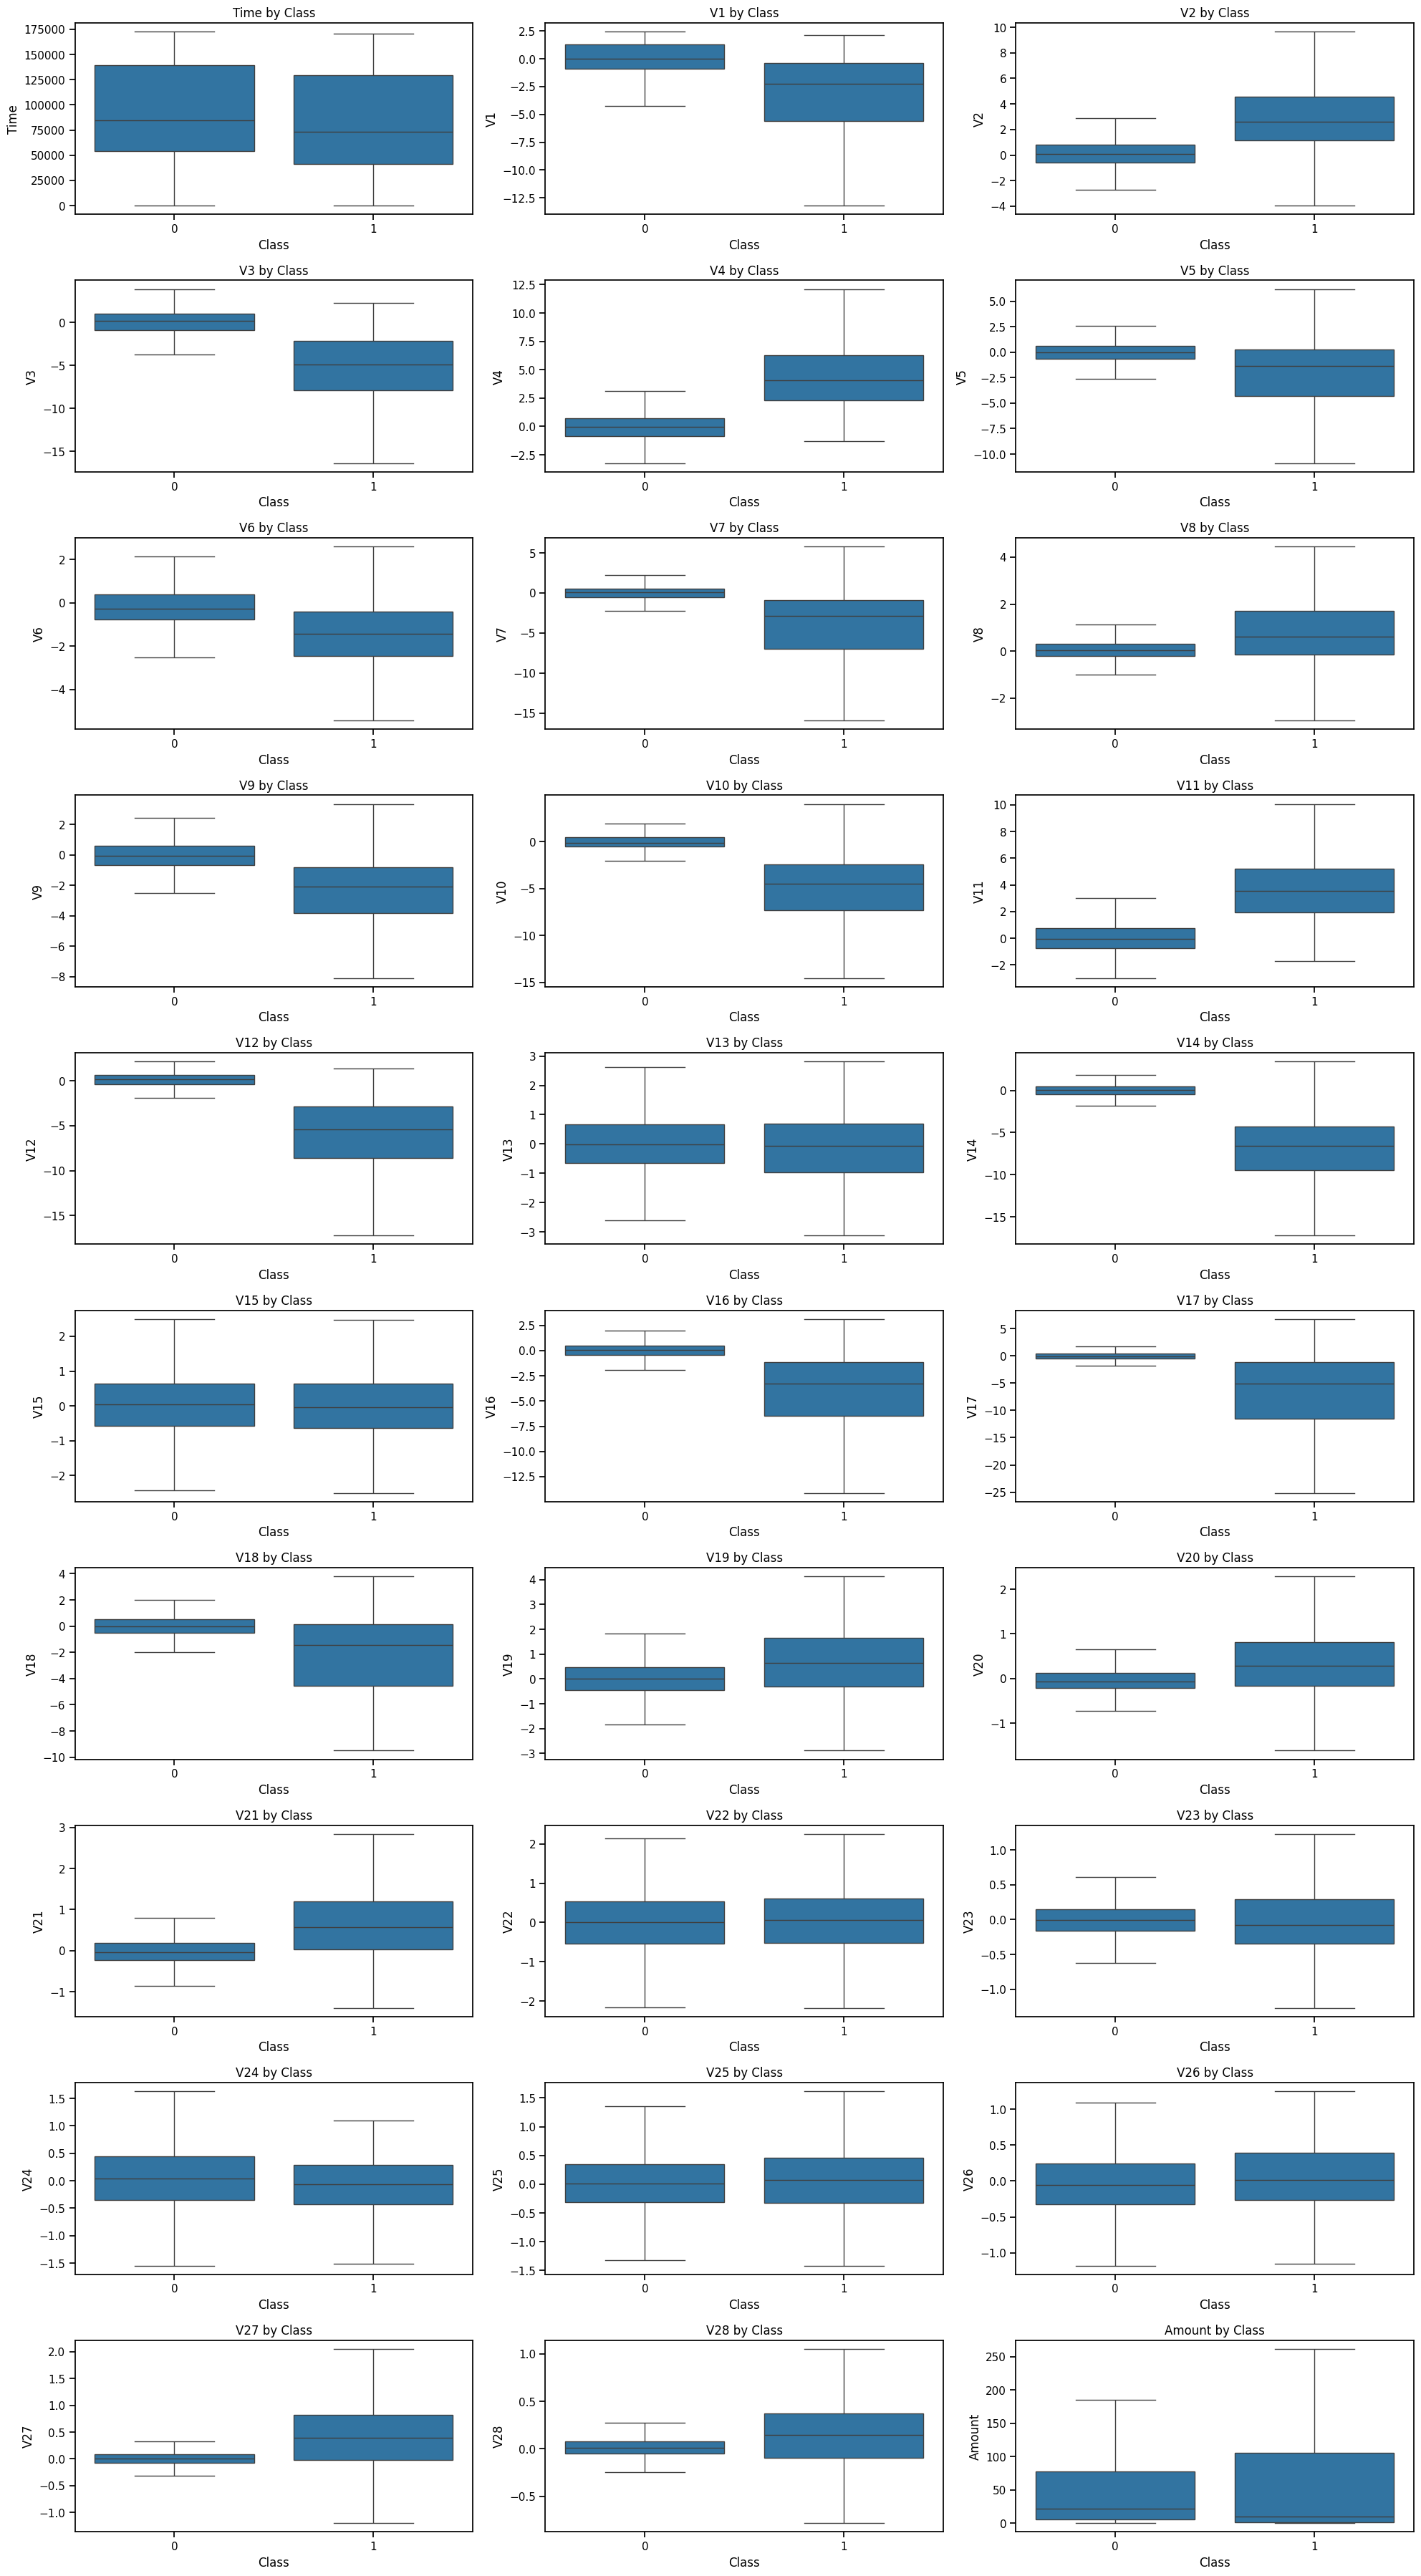

In [100]:
# Bivariate Analysis — Boxplots by Class
cols = [c for c in train.columns.tolist() if c != "Class"]
plt.figure(figsize=(20, 50))
for i, variable in enumerate(cols):
    plt.subplot(14, 3, i + 1)
    sns.boxplot(x="Class", y=variable, data=train, showfliers=False)
    plt.title(f"{variable} by Class")
    plt.tight_layout()
plt.show()


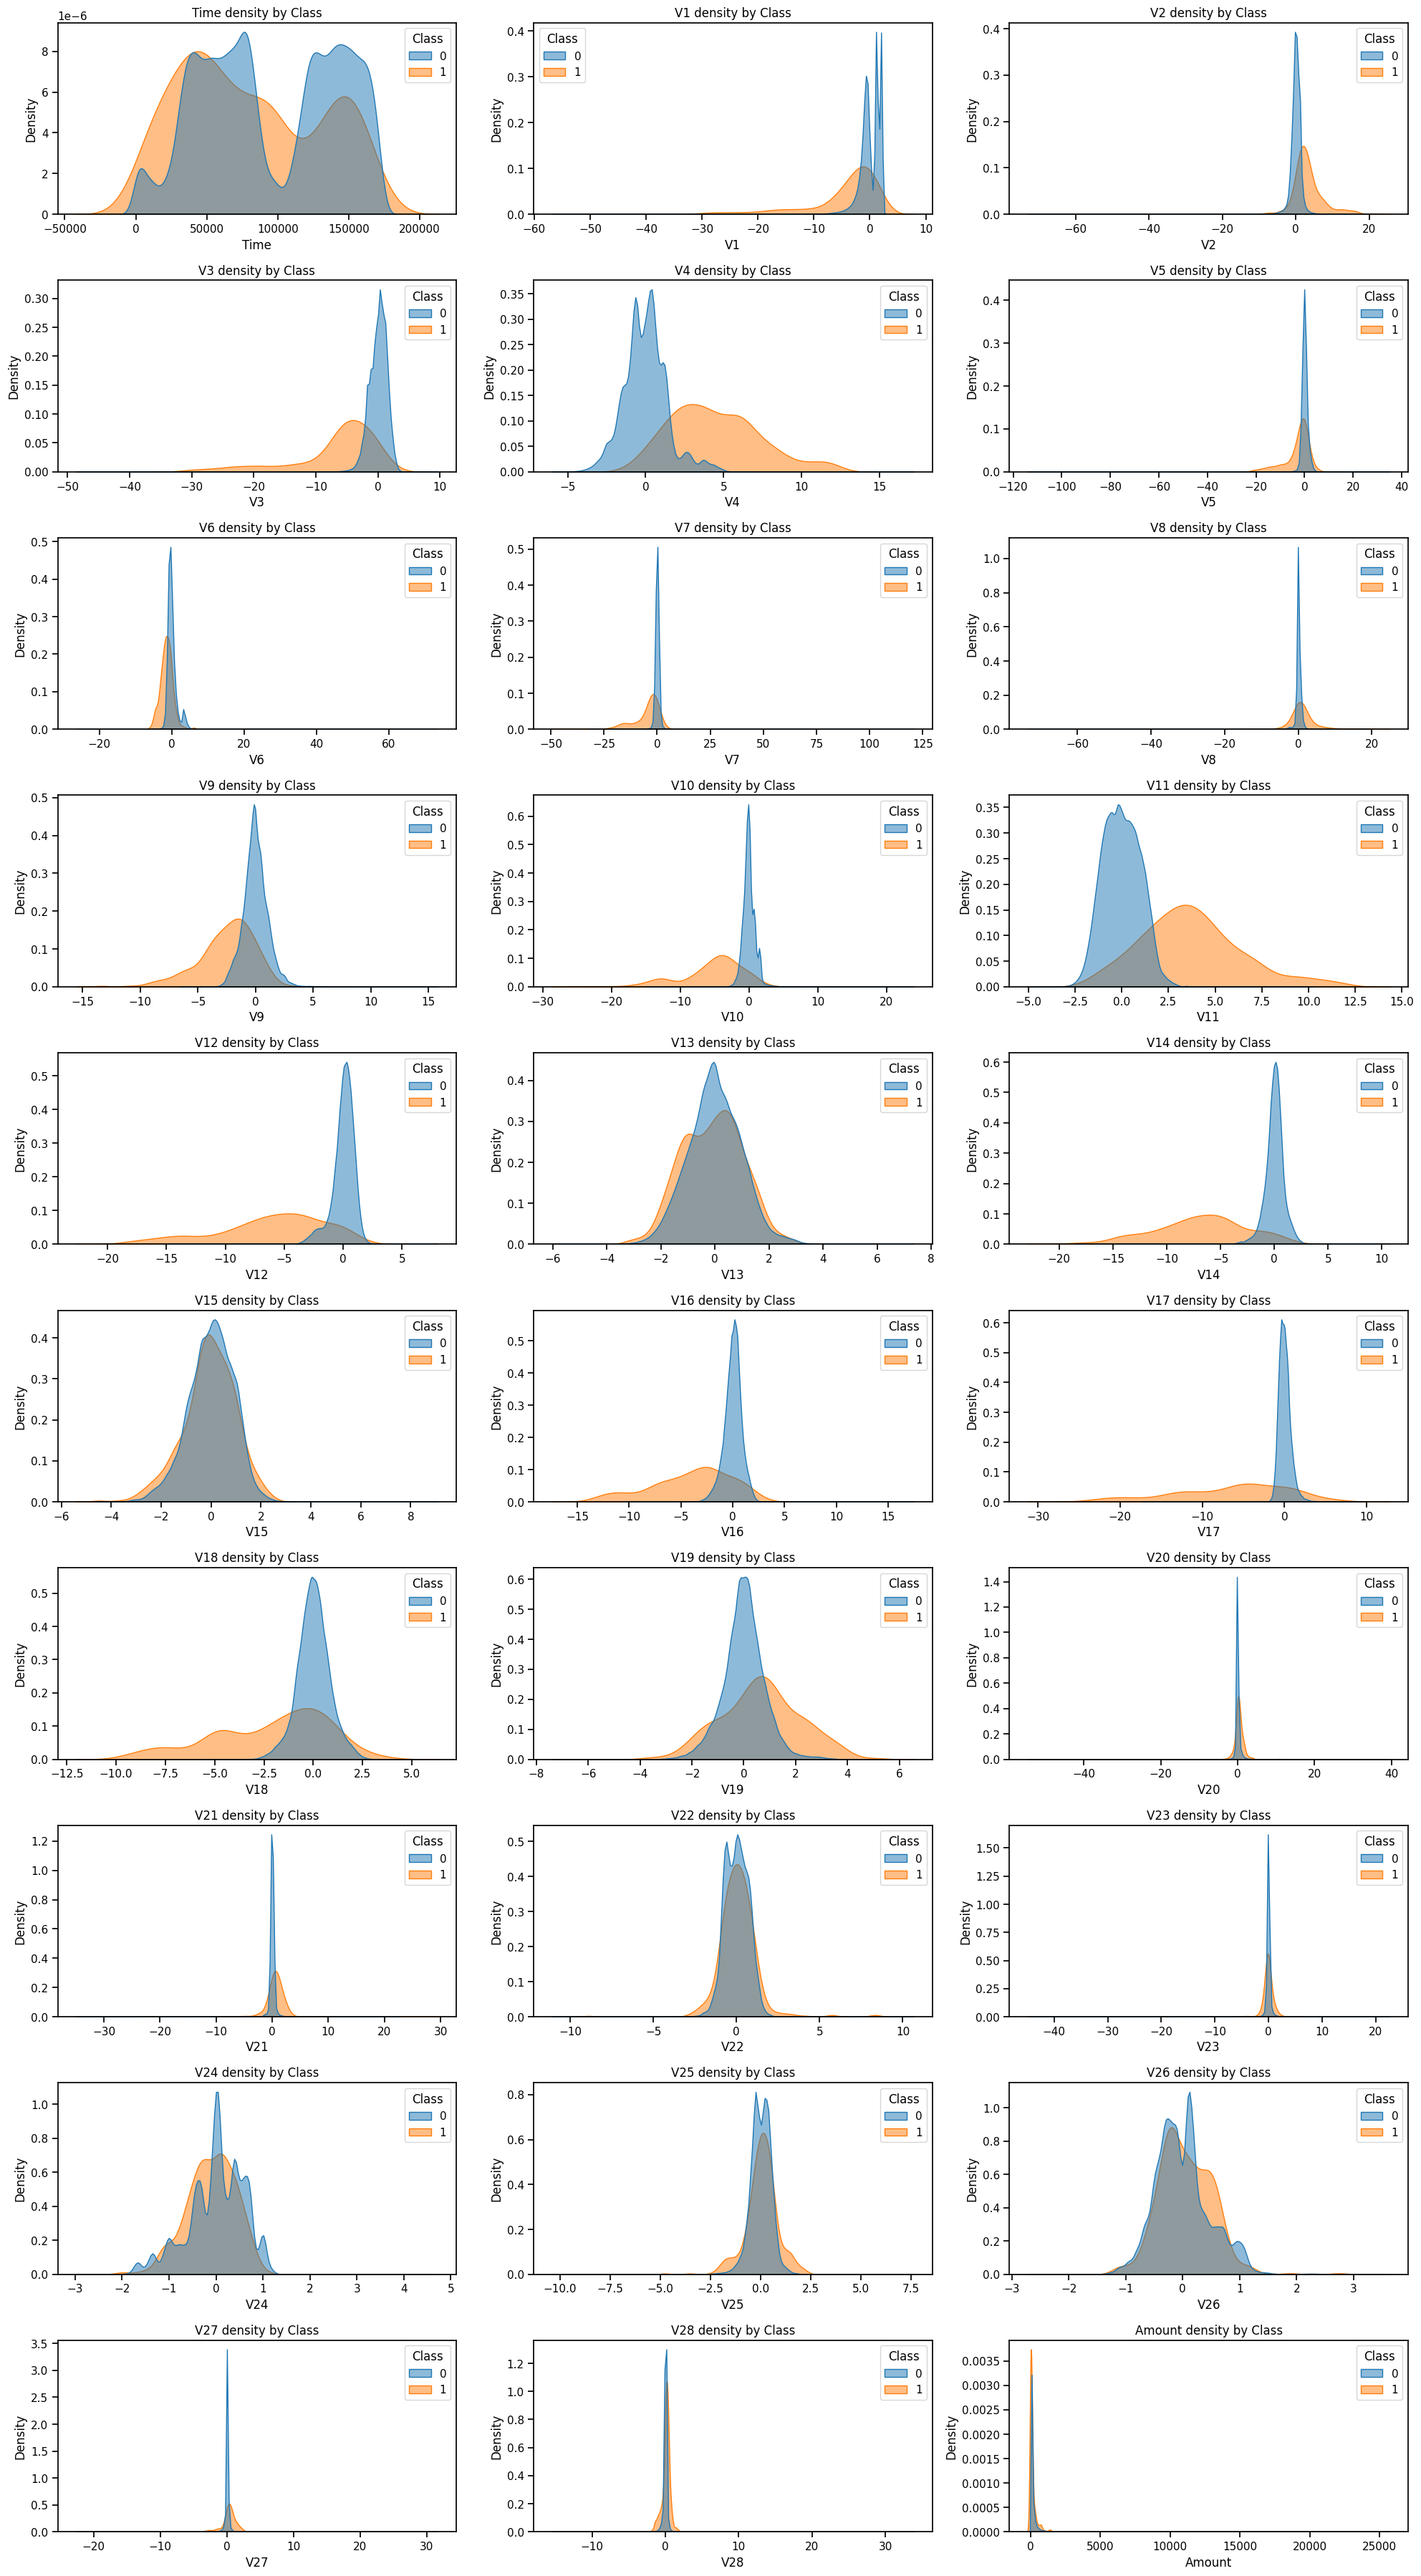

In [101]:
# Bivariate Analysis — KDE densities by Class
cols = [c for c in train.columns.tolist() if c != "Class"]
plt.figure(figsize=(20, 50))
for i, variable in enumerate(cols):
    plt.subplot(14, 3, i + 1)
    sns.kdeplot(data=train, x=variable, hue="Class", common_norm=False, fill=True, alpha=0.5, linewidth=1)
    plt.title(f"{variable} density by Class")
    plt.tight_layout()
plt.show()


For many variables the two curves substantially overlap.
Across features, fraud (Class=1) exhibits small but consistent location/scale shifts and heavier tails on a subset of components (notably V4/V10/V12/V14/V21–V23); most other components overlap strongly, so single features are not decisive.

# Feature Engineering

In [102]:
# Time-derived proxies (Time = seconds-from-start, not real timestamps)

train['Hour_from_start_mod24'] = ((train['Time'] // 3600) % 24).astype(int)
train['is_night_proxy'] = train['Hour_from_start_mod24'].isin([22,23,0,1,2,3,4,5]).astype(int)
train['is_business_hours_proxy'] = train['Hour_from_start_mod24'].between(9,17).astype(int)

train['_log_amount'] = np.log1p(train['Amount'])


features = [c for c in train.columns if c.startswith("V")] + [
    'Amount','_log_amount',
    'Hour_from_start_mod24','is_night_proxy','is_business_hours_proxy'
]
target = "Class"



# Exploratory Data Analysis (EDA)

# Imbalance + Pie

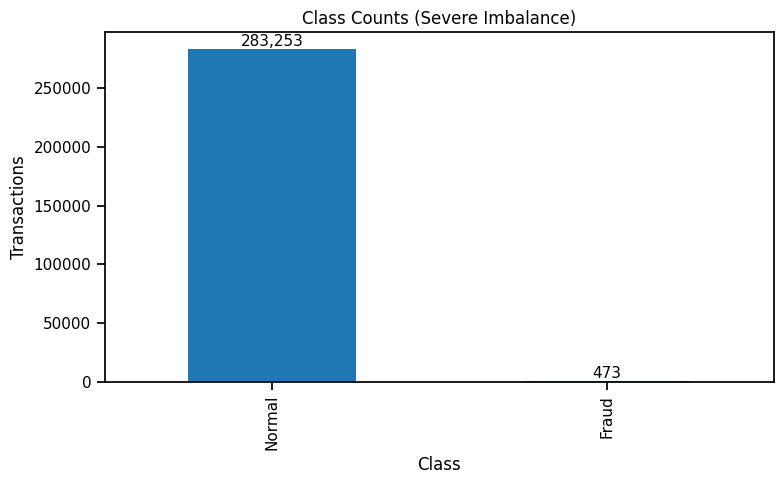

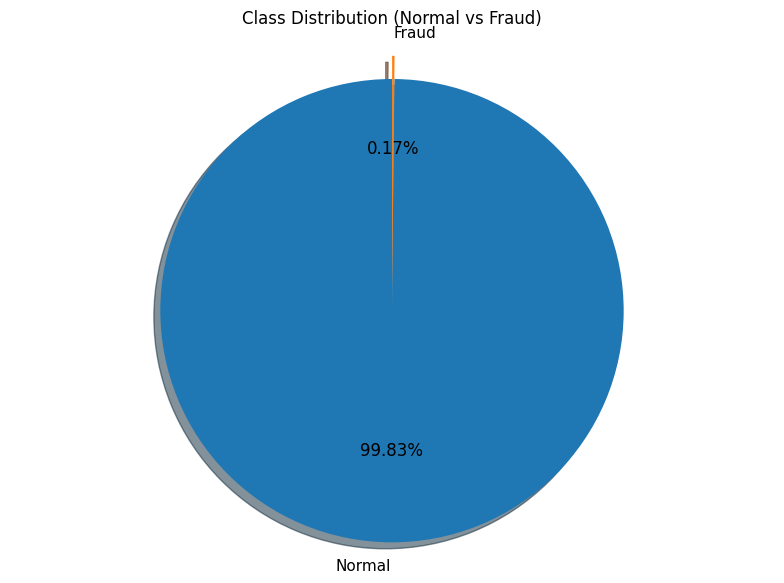

In [103]:
# standardize labels/sizes and produce plots
counts = train['Class'].value_counts().rename({0:'Normal', 1:'Fraud'})
fig, ax = plt.subplots(figsize=(8,5))
counts.plot(kind='bar', ax=ax)
for i, v in enumerate(counts.values):
    ax.text(i, v, f"{v:,}", ha='center', va='bottom', fontsize=11)
ax.set_title('Class Counts (Severe Imbalance)')
ax.set_ylabel('Transactions'); ax.set_xlabel('Class')
plt.tight_layout()
plt.show()

# pie chart
fig, ax = plt.subplots(figsize=(8,6))
ax.pie(counts.values, labels=counts.index, autopct='%1.2f%%', startangle=90, explode=[0,0.1], shadow=True)
ax.set_title('Class Distribution (Normal vs Fraud)')
ax.axis('equal')
plt.tight_layout()
plt.show()


## Amount distribution

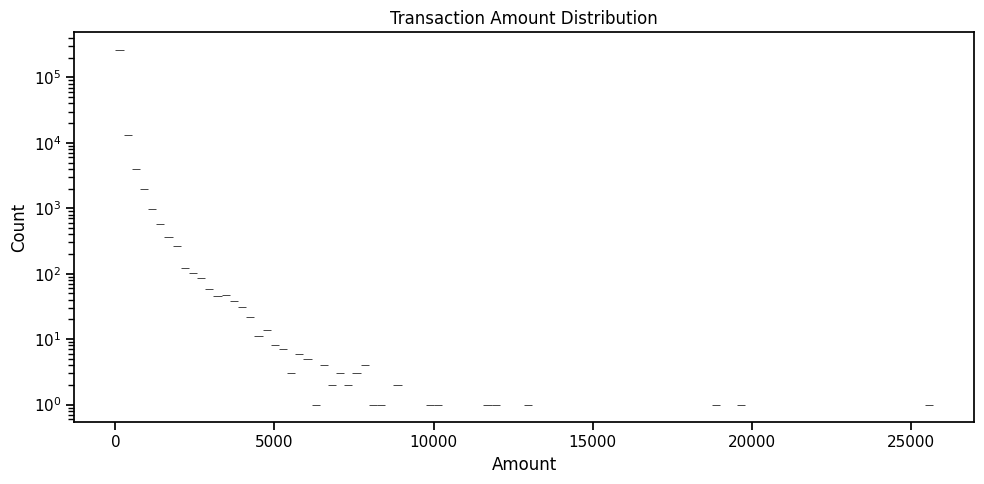

In [104]:
# univariate distribution
sns.histplot(train["Amount"], bins=100, log_scale=(False, True))
plt.title("Transaction Amount Distribution")
plt.tight_layout()
plt.show()

## log1p(Amount) — Class Separation

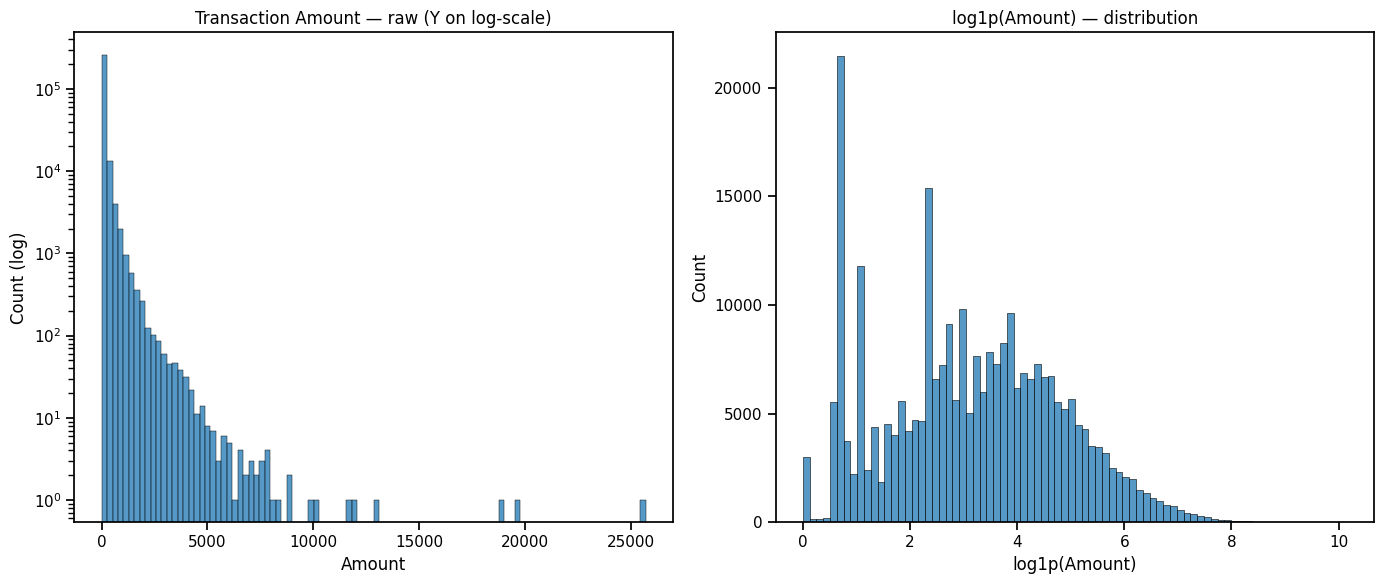

In [105]:
# inspect distributions for outliers
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Raw amount, log-scaled Y
sns.histplot(train["Amount"], bins=100, ax=axes[0])
axes[0].set_yscale("log")
axes[0].set_title("Transaction Amount — raw (Y on log-scale)")
axes[0].set_xlabel("Amount")
axes[0].set_ylabel("Count (log)")

# Log-transformed feature on X
sns.histplot(train["_log_amount"], bins=80, ax=axes[1])
axes[1].set_title("log1p(Amount) — distribution")
axes[1].set_xlabel("log1p(Amount)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


### Left: “Raw amount with a logarithmic Y-axis to reveal the long tail of transaction counts without altering the original magnitude on X.”

### Right: “Distribution of log1p(Amount). The log transform reduces skewness and makes patterns easier to model and compare.”

## Fraud Rate by Hour

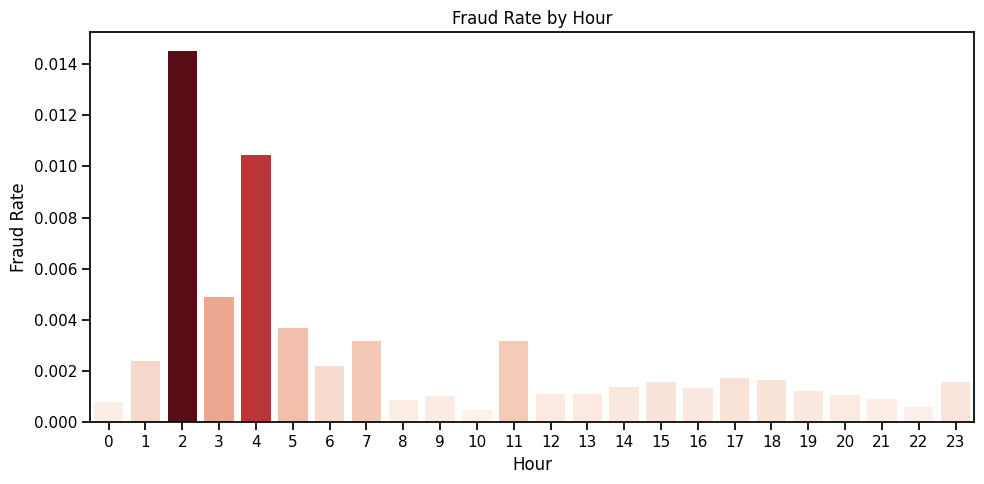

In [106]:
fraud_by_hour = train.groupby("Hour_from_start_mod24")["Class"].mean()

cmap = sns.color_palette("Reds", as_cmap=True)
vals = (fraud_by_hour / fraud_by_hour.max()).values
pal = [cmap(v) for v in vals]

sns.barplot(x=fraud_by_hour.index, y=fraud_by_hour.values, palette=pal)
plt.title("Fraud Rate by Hour")
plt.xlabel("Hour")
plt.ylabel("Fraud Rate")
plt.tight_layout()
plt.show()

## Transactions per Hour

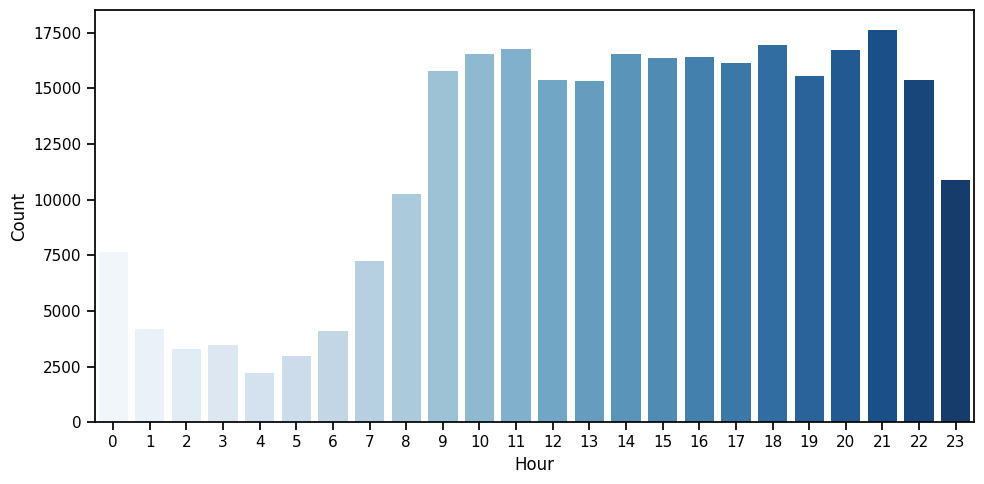

In [107]:
tx_by_hour = train.groupby("Hour_from_start_mod24")[target].count()
sns.barplot(x=tx_by_hour.index, y=tx_by_hour.values, palette='Blues')
plt.xlabel('Hour')
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Boxplot: Amount by Class

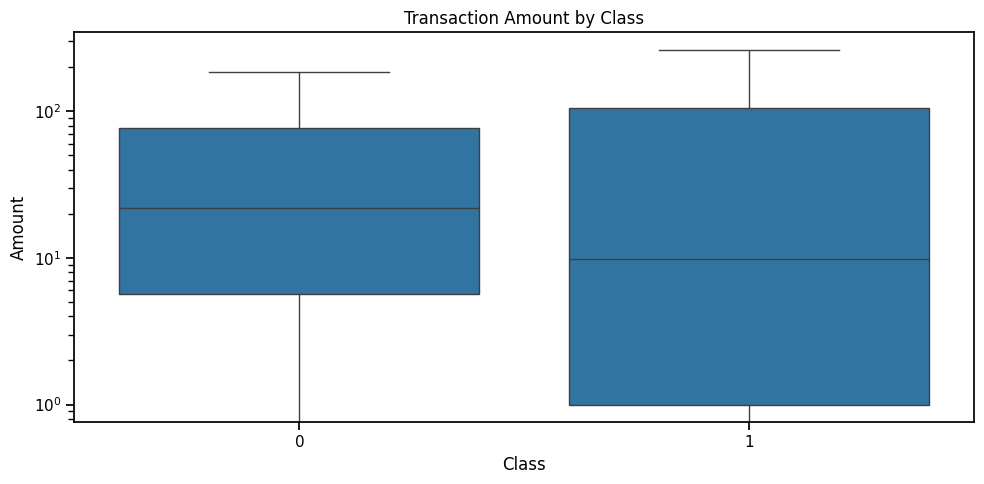

In [108]:
sns.boxplot(x= "Class", y="Amount" , data=train , showfliers=False)
plt.yscale("log")
plt.title("Transaction Amount by Class")
plt.tight_layout()
plt.show()

## Amount deciles vs fraud rate

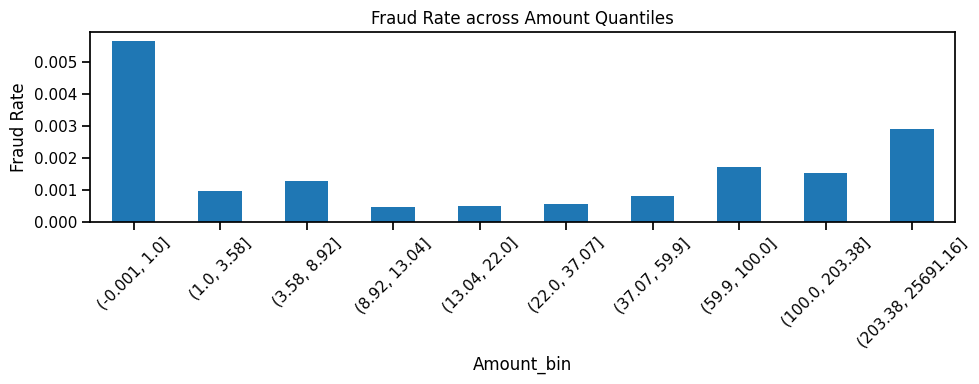

In [109]:
train["Amount_bin"] = pd.qcut(train["Amount"], q=10, duplicates="drop")
fraud_rate_bins = train.groupby("Amount_bin")["Class"].mean()
fraud_rate_bins.plot(kind="bar", figsize=(10,4))
plt.title("Fraud Rate across Amount Quantiles")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Correlation matrix

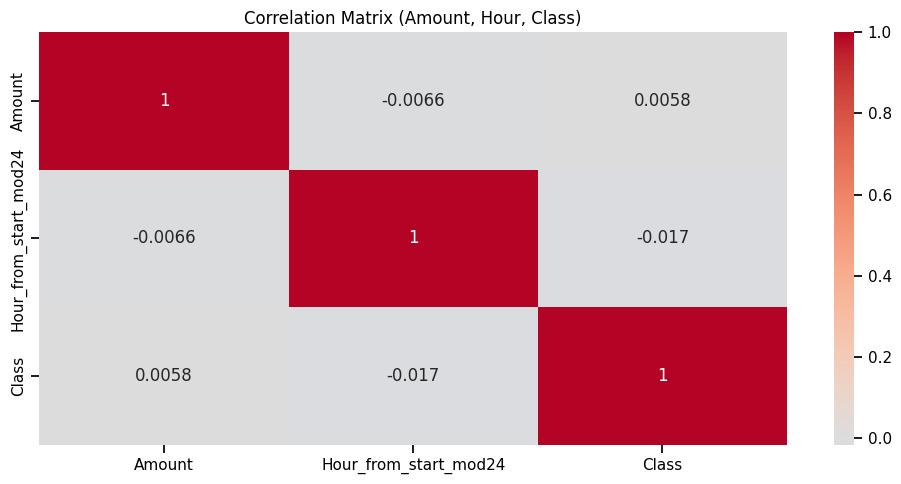

In [110]:
sns.heatmap(train[["Amount","Hour_from_start_mod24","Class"]].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Amount, Hour, Class)")
plt.tight_layout()
plt.show()


## Time Segments (Morning / Afternoon / Evening / Night)

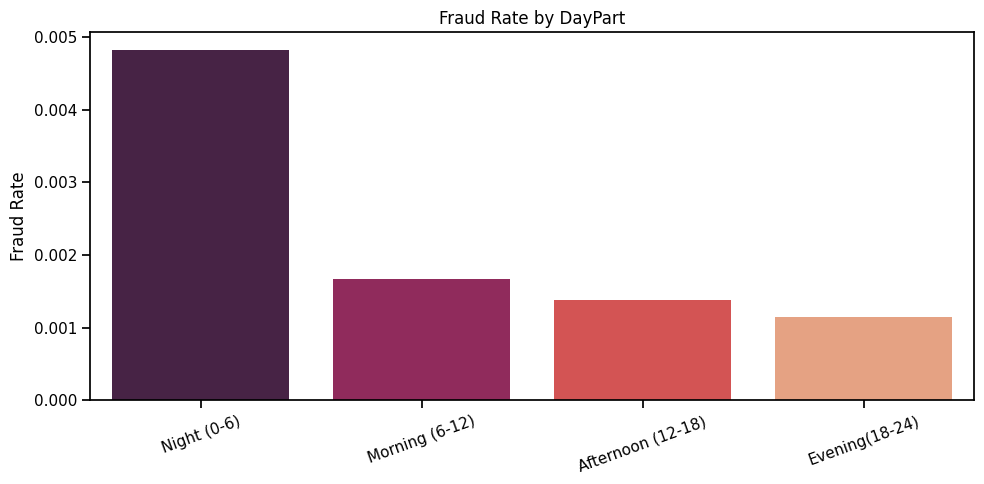

In [111]:
bins   = [0,6,12,18,24]
labels = ["Night (0-6)", "Morning (6-12)", "Afternoon (12-18)", "Evening(18-24)"]
train["DayPart"] = pd.cut(train["Hour_from_start_mod24"], bins=bins, labels=labels, right=False, include_lowest=True)


fraud_by_part  = train.groupby("DayPart")["Class"].mean().reindex(labels)

sns.barplot(x=fraud_by_part.index, y=fraud_by_part.values, palette="rocket")
plt.xticks(rotation=20)
plt.title("Fraud Rate by DayPart")
plt.xlabel("")
plt.ylabel("Fraud Rate")
plt.tight_layout()
plt.show()

## Heatmap for Hour Rate

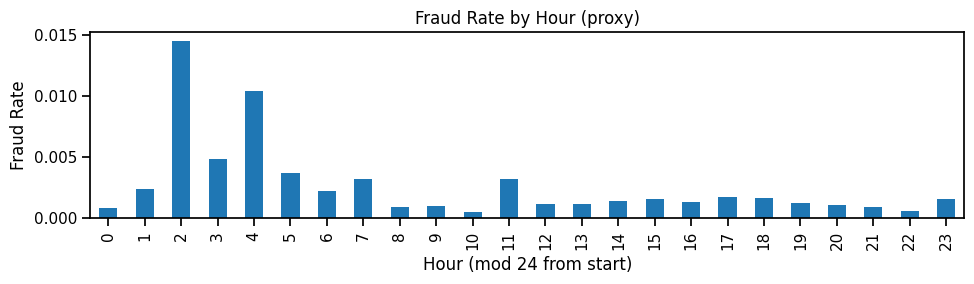

In [112]:
hour_rate = train.groupby("Hour_from_start_mod24")["Class"].mean().reindex(range(24)).fillna(0)
hour_rate.plot(kind="bar", figsize=(10,3), title="Fraud Rate by Hour (proxy)")
plt.xlabel("Hour (mod 24 from start)"); plt.ylabel("Fraud Rate")
plt.tight_layout(); plt.show()


## Barplot Fraud vs Normal

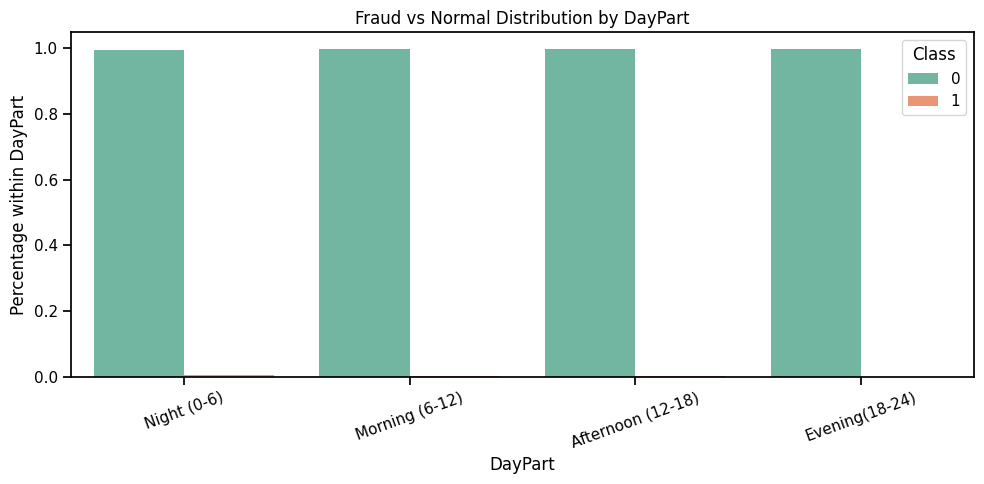

In [113]:
day_counts = train.groupby(["DayPart","Class"]).size().reset_index(name="Count")
day_total  = day_counts.groupby("DayPart")["Count"].transform("sum")
day_counts["Pct"] = day_counts["Count"] / day_total

sns.barplot(x="DayPart", y="Pct", hue="Class", data=day_counts, palette="Set2")
plt.title("Fraud vs Normal Distribution by DayPart")
plt.ylabel("Percentage within DayPart")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


## Cumulative share of fraud by Amount rank


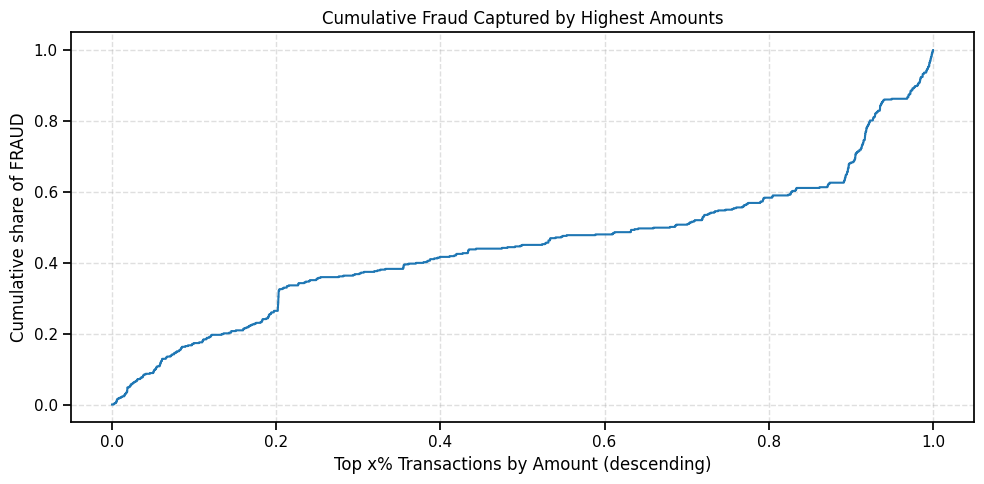

In [114]:
tmp = train[["Amount","Class"]].sort_values("Amount", ascending=False).reset_index(drop=True)
tmp["cum_tx"] = np.arange(1, len(tmp)+1) / len(tmp)
tmp["cum_fraud"] = tmp["Class"].cumsum() / tmp["Class"].sum()

plt.plot(tmp["cum_tx"], tmp["cum_fraud"])
plt.xlabel("Top x% Transactions by Amount (descending)")
plt.ylabel("Cumulative share of FRAUD")
plt.title("Cumulative Fraud Captured by Highest Amounts")
plt.grid(True, ls="--", alpha=0.4)
plt.tight_layout()
plt.show()


## Time-based Split (no look-ahead leakage)

In [115]:
df_sorted = train.sort_values("Time").reset_index(drop=True)
cut = int(0.8 * len(df_sorted))
train_df, test_df = df_sorted.iloc[:cut], df_sorted.iloc[cut:]

# Inner validation from train (time-ordered)
cut_in = int(0.8 * len(train_df))
train__df, val_df = train_df.iloc[:cut_in], train_df.iloc[cut_in:]

X_train , y_train = train__df[features], train__df[target].astype(int)
X_val   , y_val   = val_df[features]  , val_df[target].astype(int)
X_test  , y_test  = test_df[features] , test_df[target].astype(int)

print("Inner-Train:", len(X_train), "| Val:", len(X_val), "| Test:", len(X_test))
print("Train prevalence:", y_train.mean(), "| Test prevalence:", y_test.mean())


Inner-Train: 181584 | Val: 45396 | Test: 56746
Train prevalence: 0.001910961318177813 | Test prevalence: 0.0013040566735981391


# Utilities: Metrics, Thresholds, Cost

In [116]:
def evaluate_block(y_true, y_score, thr=0.5):
    y_pred = (y_score >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return dict(
        threshold=float(thr),
        precision=precision_score(y_true, y_pred, zero_division=0),
        recall=recall_score(y_true, y_pred),
        f1=f1_score(y_true, y_pred, zero_division=0),
        roc_auc=roc_auc_score(y_true, y_score),
        auprc=average_precision_score(y_true, y_score),
        brier=brier_score_loss(y_true, y_score),
        tp=int(tp), fp=int(fp), fn=int(fn), tn=int(tn)
    )

def thr_for_precision(y_true, y_score, target_p=0.90):
    ps, rs, ths = precision_recall_curve(y_true, y_score)
    hits = np.where(ps[:-1] >= target_p)[0]
    if hits.size:
        i = hits[0]
        return float(ths[i]), float(ps[i]), float(rs[i])
    i = np.argmax(0.5*ps[:-1] + 0.5*rs[:-1])
    return float(ths[i]), float(ps[i]), float(rs[i])


def thr_min_cost(y_true , y_score , cost_fp=COST_FP , cost_fn=COST_FN, grid=1001):
    best_thr , best_cost = 0.5, float("inf")
    for t in np.linspace(0,1, grid):
        yhat = (y_score >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true ,yhat, labels=[0,1]).ravel()
        cost = fp*cost_fp + fn*cost_fn
        if cost < best_cost:
            best_thr , best_cost = float(t), float(cost)
    return best_thr , best_cost

def realized_cost(y_true, y_score, thr, cost_fp=COST_FP, cost_fn=COST_FN):
    yhat = (y_score >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0,1]).ravel()
    return fp*cost_fp + fn*cost_fn

def plot_pr_roc(y_true, y_score ,title):
    ps,rs , _ = precision_recall_curve(y_true , y_score)
    plt.plot(rs, ps)
    plt.axhline(y_true.mean(), ls="--", alpha=0.5)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"{title} — PR (AP={average_precision_score(y_true,y_score):.3f})")
    plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr)
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(f"{title} — ROC (AUC={roc_auc_score(y_true,y_score):.3f})")
    plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

def reliability_plot(y_true, y_score, title, bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_score, n_bins=bins, strategy="quantile")
    plt.plot(prob_pred, prob_true, marker="o")
    plt.plot([0,1],[0,1], "--", alpha=0.6)
    plt.xlabel("Predicted probability"); plt.ylabel("Empirical probability")
    plt.title(title + f" — Brier={brier_score_loss(y_true, y_score):.4f}")
    plt.grid(True, ls="--", alpha=0.4); plt.tight_layout(); plt.show()

def expected_calibration_error(y_true, y_prob, n_bins=15):
    """
    Simple (non-standardized) ECE: weighted avg |acc - conf| over quantized bins.
    For formal comparisons, prefer standardized definitions.
    """
    bins = np.linspace(0.0, 1.0, n_bins+1)
    idx = np.digitize(y_prob, bins) - 1
    ece = 0.0
    for b in range(n_bins):
        mask = (idx == b)
        if not np.any(mask):
            continue
        conf = y_prob[mask].mean()
        acc  = y_true[mask].mean()
        ece += (mask.mean()) * abs(acc - conf)
    return float(ece)

rng = np.random.default_rng(SEED)
def bootstrap_ci(metric_fn, y_true, y_score, B=300, alpha=0.05):
    n = len(y_true)
    vals = []
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        vals.append(metric_fn(y_true[idx], y_score[idx]))
    lo = np.quantile(vals, alpha/2)
    hi = np.quantile(vals, 1 - alpha/2)
    return float(lo), float(hi)


def sweep_thresholds(y_true, y_prob, costs=(COST_FP, COST_FN)):
    ths = np.linspace(0, 1, 101)
    rows = []
    for t in ths:
        yhat = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0,1]).ravel()
        prec = precision_score(y_true, yhat, zero_division=0)
        rec  = recall_score(y_true, yhat)
        f1   = f1_score(y_true, yhat, zero_division=0)
        cost = fp*costs[0] + fn*costs[1]
        rows.append([t, prec, rec, f1, tp, fp, fn, tn, cost])
    return pd.DataFrame(rows, columns=["thr","precision","recall","f1","tp","fp","fn","tn","cost"])

def plot_alerts_and_savings(df_sweep, title):
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    # Alerts = predicted positives = tp+fp
    ax[0].plot(df_sweep["thr"], df_sweep["tp"]+df_sweep["fp"])
    ax[0].set_title(title+" — Alerts vs Threshold"); ax[0].set_xlabel("Threshold"); ax[0].set_ylabel("#Alerts")
    # Savings = (tp * FN_cost) - (fp * FP_cost)
    savings = df_sweep["tp"]*COST_FN - df_sweep["fp"]*COST_FP
    ax[1].plot(df_sweep["thr"], savings)
    ax[1].set_title(title+" — Net Savings vs Threshold"); ax[1].set_xlabel("Threshold"); ax[1].set_ylabel("Net Savings ($)")
    plt.tight_layout(); plt.show()


## Baseline Logistic + RF

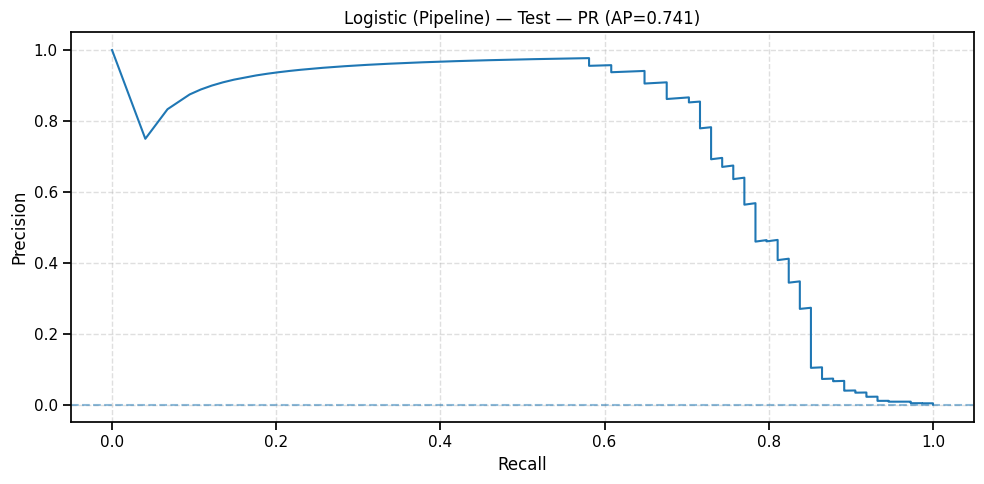

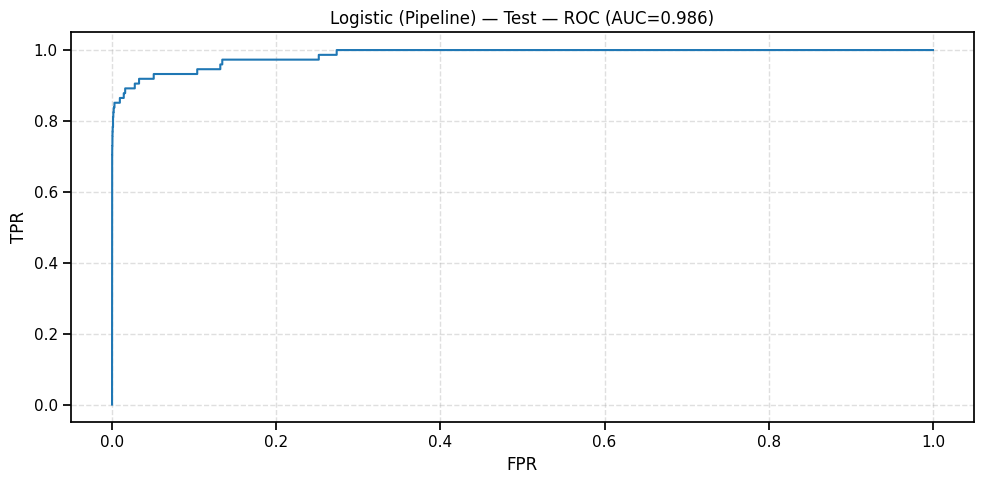

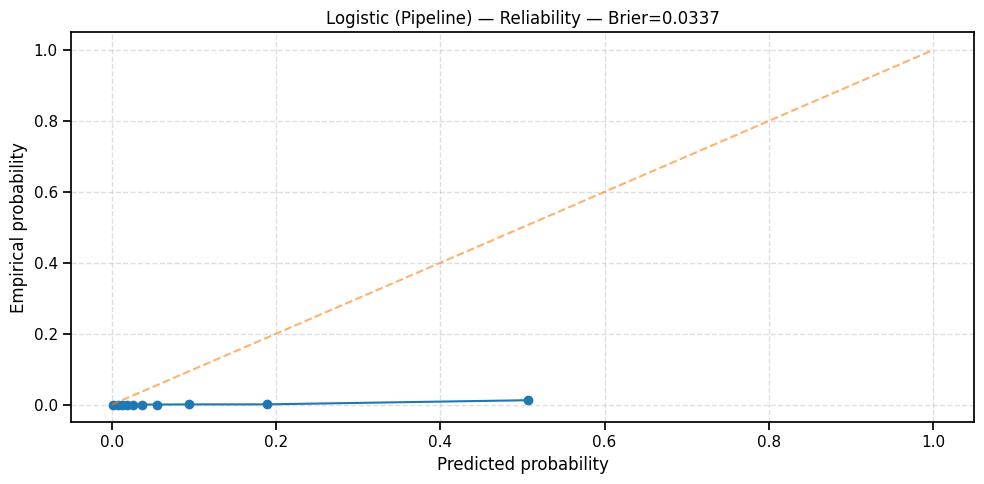

[Logistic|Pipeline] VAL AUPRC: 0.7749693650102897
[Logistic|Pipeline] TEST AUPRC: 0.7414676125025982


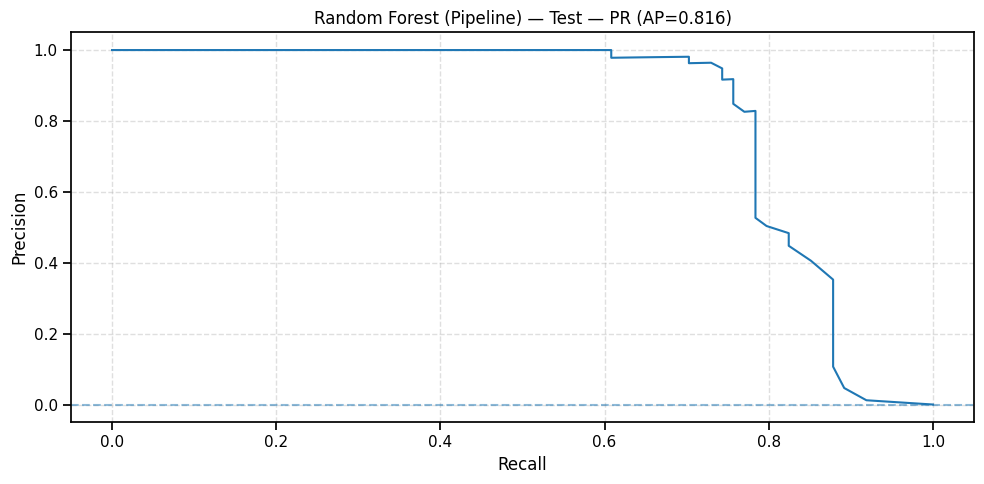

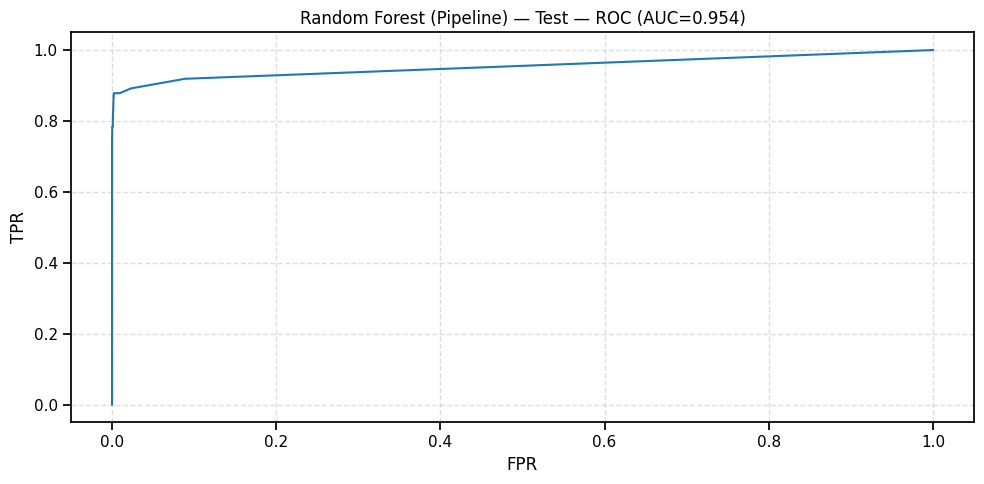

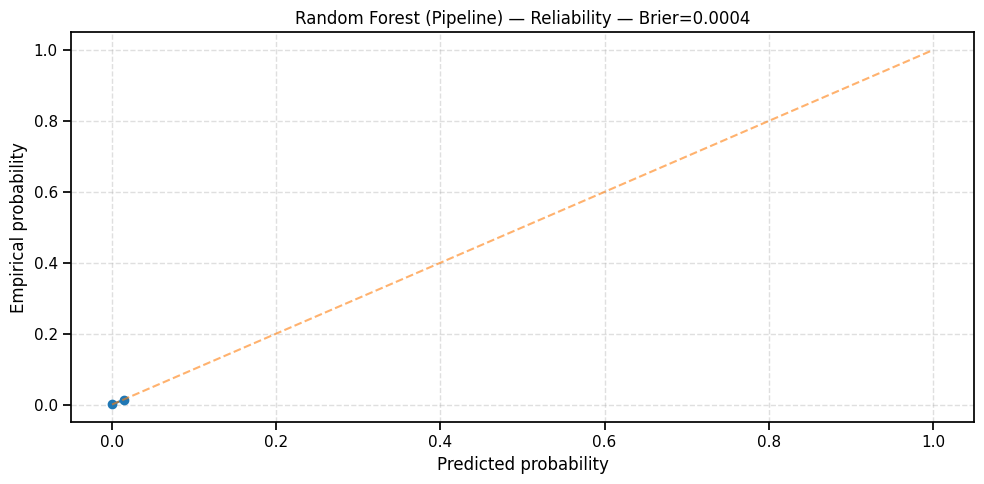

[RF|Pipeline] VAL AUPRC: 0.759396667218056
[RF|Pipeline] TEST AUPRC: 0.8159857361551065


In [117]:
# Logistic Regression
logit_pipe = ImbPipeline(steps=[
    ("scaler", StandardScaler(with_mean=True)),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=SEED))
])
logit_pipe.fit(X_train, y_train)

val_log_proba  = logit_pipe.predict_proba(X_val)[:, 1]
test_log_proba = logit_pipe.predict_proba(X_test)[:, 1]


plot_pr_roc(y_test, test_log_proba, "Logistic (Pipeline) — Test")
reliability_plot(y_test, test_log_proba, "Logistic (Pipeline) — Reliability")
print("[Logistic|Pipeline] VAL AUPRC:",  average_precision_score(y_val , val_log_proba))
print("[Logistic|Pipeline] TEST AUPRC:", average_precision_score(y_test, test_log_proba))

# Random Forest
rf_pipe = ImbPipeline(steps=[
    ("clf", RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=SEED,
        n_jobs=-1
    ))
])
rf_pipe.fit(X_train, y_train)

val_rf_proba  = rf_pipe.predict_proba(X_val)[:, 1]
test_rf_proba = rf_pipe.predict_proba(X_test)[:, 1]


plot_pr_roc(y_test, test_rf_proba, "Random Forest (Pipeline) — Test")
reliability_plot(y_test, test_rf_proba, "Random Forest (Pipeline) — Reliability")
print("[RF|Pipeline] VAL AUPRC:",  average_precision_score(y_val , val_rf_proba))
print("[RF|Pipeline] TEST AUPRC:", average_precision_score(y_test, test_rf_proba))


##  Strong Model — XGBoost

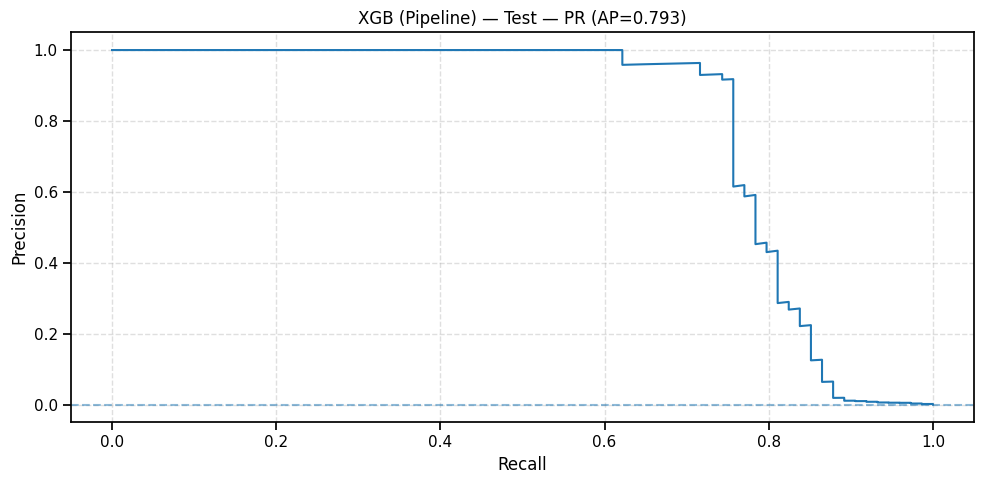

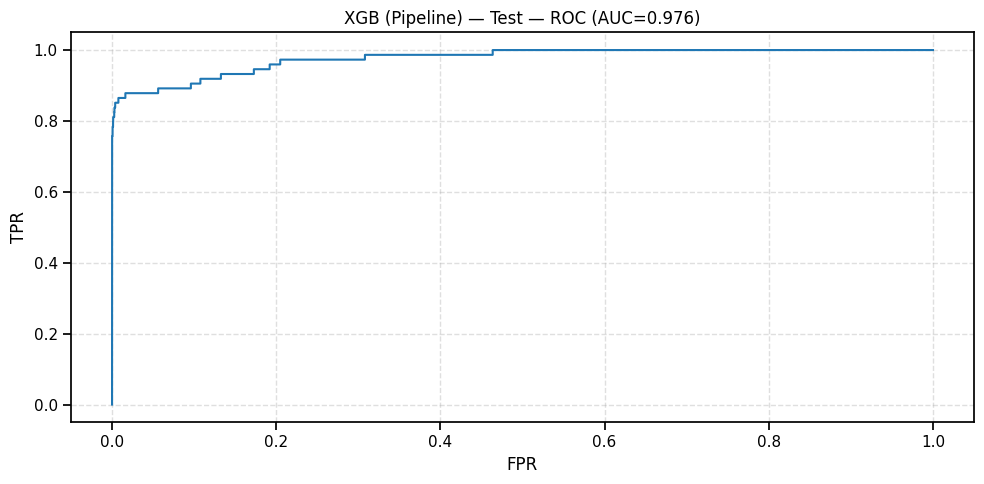

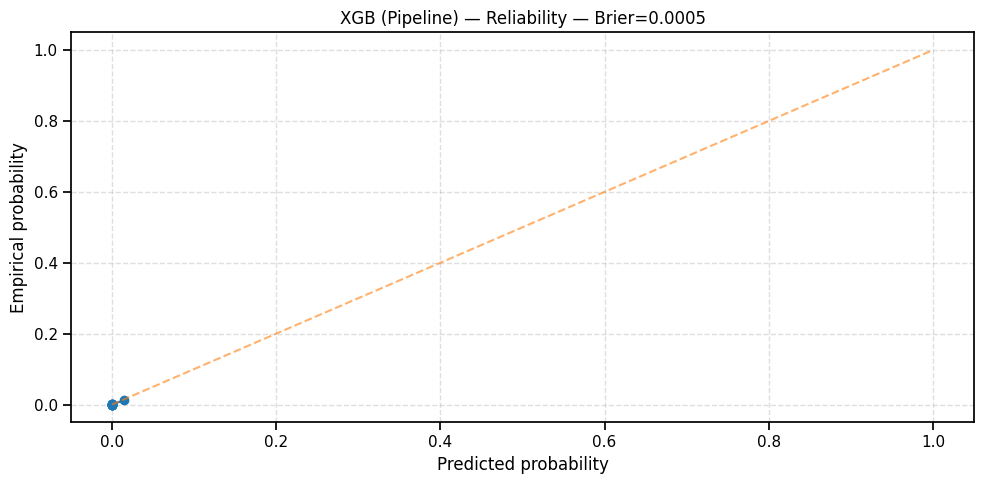

[XGB|Pipeline] VAL AUPRC: 0.7779202381127426
[XGB|Pipeline] TEST AUPRC: 0.7929107058649759


In [118]:
pos, neg = int((y_train==1).sum()), int((y_train==0).sum())
spw = neg / max(1, pos)  # scale_pos_weight ≈ imbalance ratio

xgb_pipe = ImbPipeline(steps=[
    ("model", XGBClassifier(
        n_estimators=600, max_depth=4, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        tree_method="hist", random_state=SEED,
        scale_pos_weight=spw, n_jobs=-1, eval_metric="aucpr"
    ))
])
xgb_pipe.fit(X_train, y_train)

val_xgb_proba  = xgb_pipe.predict_proba(X_val)[:, 1]
test_xgb_proba = xgb_pipe.predict_proba(X_test)[:, 1]

plot_pr_roc(y_test, test_xgb_proba, "XGB (Pipeline) — Test")
reliability_plot(y_test, test_xgb_proba, "XGB (Pipeline) — Reliability")
print("[XGB|Pipeline] VAL AUPRC:",  average_precision_score(y_val, val_xgb_proba))
print("[XGB|Pipeline] TEST AUPRC:", average_precision_score(y_test, test_xgb_proba))


# Calibration (Isotonic) with TimeSeriesSplit on TRAIN

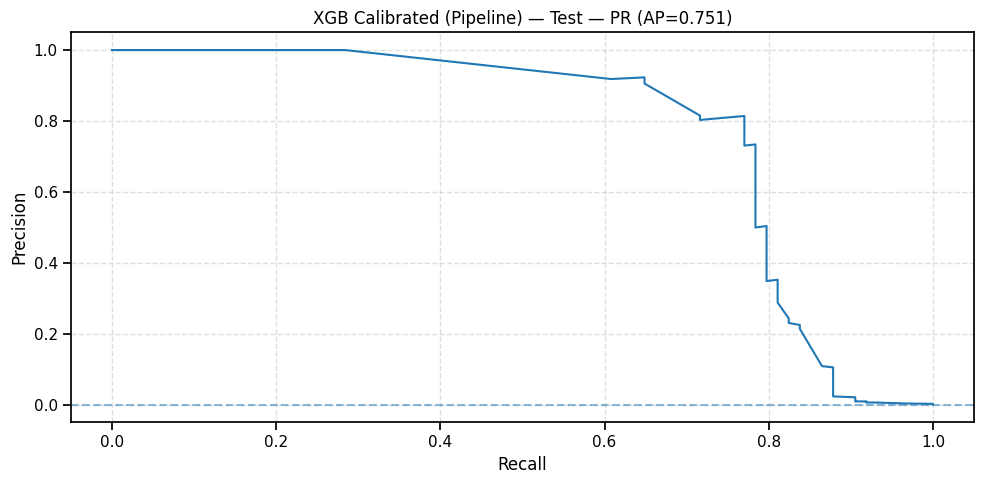

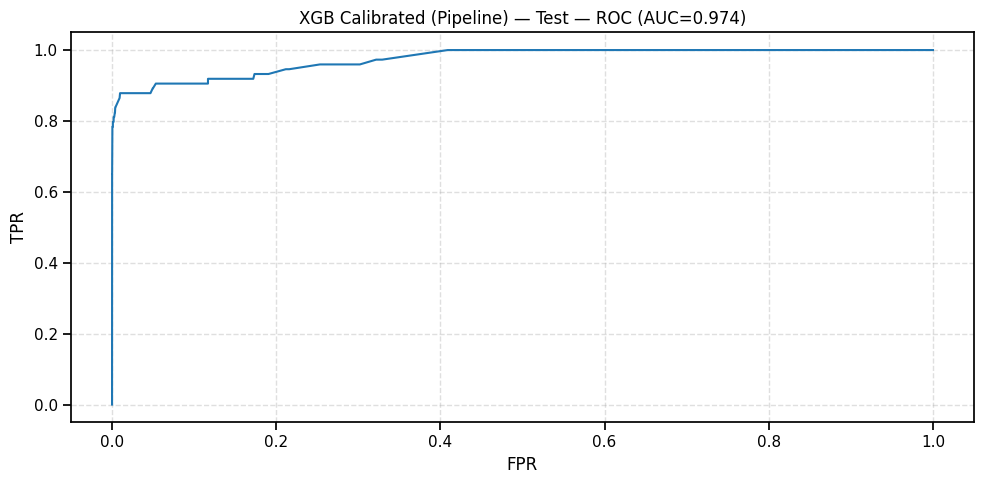

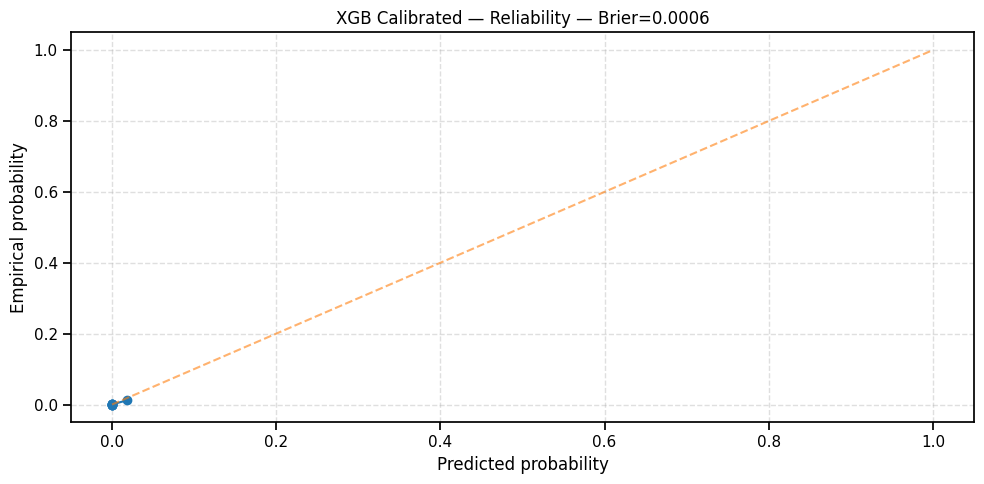

[XGB-Cal|Pipeline] VAL AUPRC: 0.7431999968437792
[XGB-Cal|Pipeline] TEST AUPRC: 0.7512582520688527
ECE[Test] XGB-Cal: 0.0007095307056611635


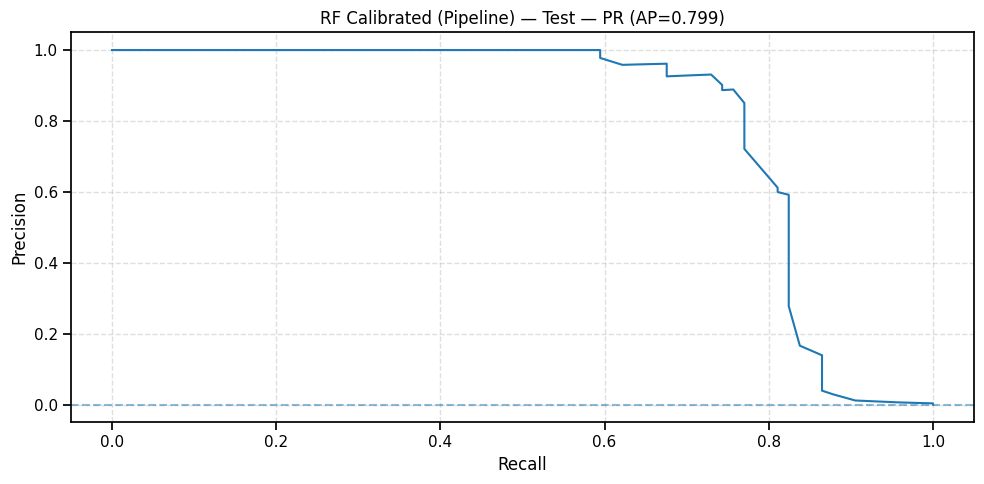

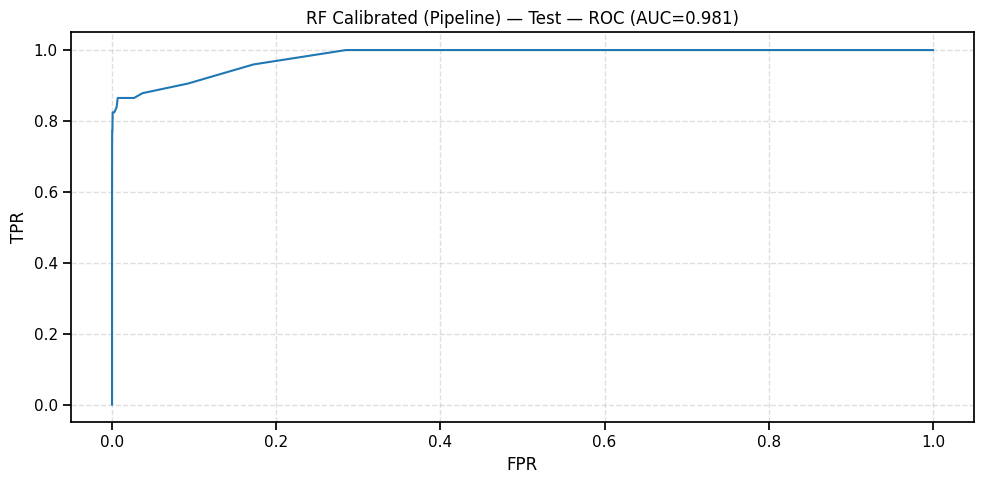

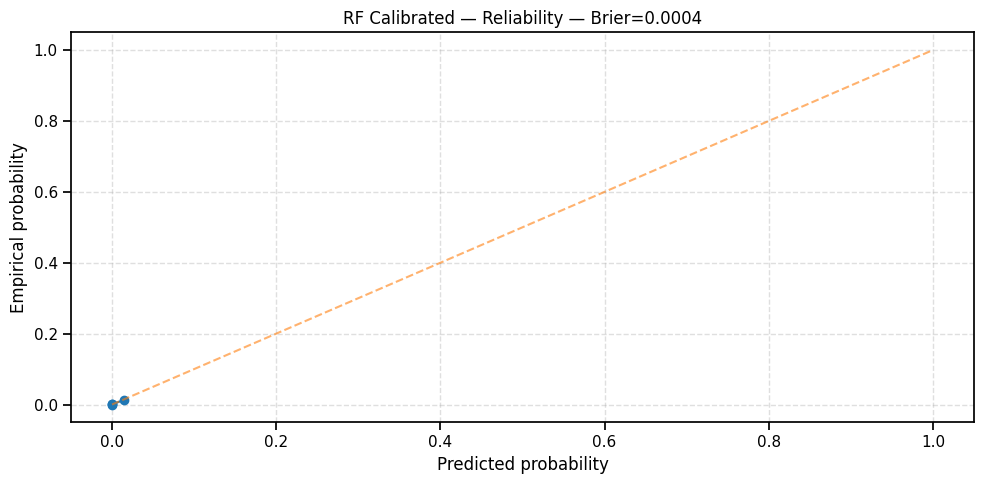

[RF-Cal] VAL AUPRC: 0.76194581750697
[RF-Cal] TEST AUPRC: 0.7985448082041563
ECE[Test] RF-Cal : 0.00029607425628749227


In [119]:
cal_cv = TimeSeriesSplit(n_splits=3)

# Calibrated XGB
xgb_cal = CalibratedClassifierCV(estimator=xgb_pipe, method="isotonic", cv=cal_cv)
xgb_cal.fit(X_train, y_train)
val_xgb_cal  = xgb_cal.predict_proba(X_val)[:, 1]
test_xgb_cal = xgb_cal.predict_proba(X_test)[:, 1]

plot_pr_roc(y_test, test_xgb_cal, "XGB Calibrated (Pipeline) — Test")
reliability_plot(y_test, test_xgb_cal, "XGB Calibrated — Reliability")
print("[XGB-Cal|Pipeline] VAL AUPRC:",  average_precision_score(y_val, val_xgb_cal))
print("[XGB-Cal|Pipeline] TEST AUPRC:", average_precision_score(y_test, test_xgb_cal))
print("ECE[Test] XGB-Cal:", expected_calibration_error(y_test.values, test_xgb_cal, n_bins=15))


# Calibrated RF
rf_cal = CalibratedClassifierCV(estimator=rf_pipe, method="isotonic", cv=cal_cv)
rf_cal.fit(X_train, y_train)
val_rf_cal  = rf_cal.predict_proba(X_val)[:, 1]
test_rf_cal = rf_cal.predict_proba(X_test)[:, 1]

plot_pr_roc(y_test, test_rf_cal, "RF Calibrated (Pipeline) — Test")
reliability_plot(y_test, test_rf_cal, "RF Calibrated — Reliability")
print("[RF-Cal] VAL AUPRC:",  average_precision_score(y_val,  val_rf_cal))
print("[RF-Cal] TEST AUPRC:", average_precision_score(y_test, test_rf_cal))
print("ECE[Test] RF-Cal :", expected_calibration_error(y_test.values, test_rf_cal,  n_bins=15))




## Cost Assumptions for Decisions

We choose the operating threshold τ by minimizing **expected business cost on the validation set**, then report results on the held-out test set.

**False Negative (FN) — missed fraud (C_FN):**
• Unrecovered transaction amount  
• Chargeback/processing fees  
• Support/ops time

**False Positive (FP) — unnecessary review (C_FP):**
• Analyst time per alert × loaded hourly rate  
• Optional customer-friction penalty

**Base scenario for headline numbers:** C_FN = $200, C_FP = $5  
These are placeholders. Replace with your own estimates before finalizing results.

**Sensitivity analysis:** evaluate multiple cost pairs to show how τ and alert volume change:
• S1: C_FN=200, C_FP=5  
• S2: C_FN=200, C_FP=20  
• S3: C_FN=800, C_FP=5  
• S4: C_FN=100, C_FP=10

**Reporting (per model):**
• τ* chosen on validation for each scenario  
• Test set: total cost, FP/FN counts, alert volume  
• “Cost multiple vs. oracle (same alerts)” = model cost ÷ theoretical minimum cost at the same alert count  
• PR-AUC and recall at FPR = {0.1%, 0.5%, 1%} for context

PR-AUC remains the primary quality metric; the decision threshold is set by business cost. Use calibrated probabilities where available.


In [120]:
def biz_total_cost(y_true, y_prob, thr, C_FN, C_FP):
    yhat = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0,1]).ravel()
    return C_FN*fn + C_FP*fp, int(fp), int(fn), int(tp), int(tn), int(yhat.sum())

def biz_best_threshold(y_true, y_prob, C_FN, C_FP, grid=2001):
    ths = np.linspace(0.0, 1.0, grid)
    best_t, best_c = 0.5, float("inf")
    for t in ths:
        c, *_ = biz_total_cost(y_true, y_prob, t, C_FN, C_FP)
        if c < best_c:
            best_t, best_c = float(t), float(c)
    return best_t

def biz_recall_at_fpr(y_true, y_prob, target_fpr):
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    i = np.searchsorted(fpr, target_fpr, side="left")
    i = min(i, len(tpr)-1)
    return float(tpr[i])

def biz_oracle_cost_same_alerts(y_true, alerts, C_FN, C_FP):
    pos = int(np.asarray(y_true).sum())
    if alerts <= pos:
        oracle_fp, oracle_fn = 0, pos - alerts
    else:
        oracle_fp, oracle_fn = alerts - pos, 0
    return oracle_fp*C_FP + oracle_fn*C_FN

In [121]:
C_FN, C_FP = 200.0, 5.0  # replace with your estimates for the headline run

models = {
    "Logistic": (val_log_proba, test_log_proba),
    "RF-Cal"  : (val_rf_cal,   test_rf_cal),
    "XGB-Cal" : (val_xgb_cal,  test_xgb_cal),
}

rows = []
for name, (p_val, p_test) in models.items():
    thr = biz_best_threshold(y_val.values, p_val, C_FN, C_FP)
    cost, fp, fn, tp, tn, alerts = biz_total_cost(y_test.values, p_test, thr, C_FN, C_FP)
    oracle = biz_oracle_cost_same_alerts(y_test.values, alerts, C_FN, C_FP)
    rows.append({
        "model": name,
        "threshold": float(thr),
        "alerts": alerts,
        "FP": fp, "FN": fn, "TP": tp, "TN": tn,
        "test_cost": float(cost),
        "oracle_cost_same_alerts": float(oracle),
        "cost_multiple_vs_oracle": float(cost / max(1.0, oracle)),
        "AP_test": float(average_precision_score(y_test.values, p_test)),
        "recall@FPR=0.1%": biz_recall_at_fpr(y_test.values, p_test, 0.001),
        "recall@FPR=0.5%": biz_recall_at_fpr(y_test.values, p_test, 0.005),
        "recall@FPR=1%":   biz_recall_at_fpr(y_test.values, p_test, 0.010),
    })

import pandas as pd
biz_base = pd.DataFrame(rows).sort_values(["test_cost","cost_multiple_vs_oracle"])
display(biz_base.round(4))

,model,threshold,alerts,FP,FN,TP,TN,test_cost,oracle_cost_same_alerts,cost_multiple_vs_oracle,AP_test,recall@FPR=0.1%,recall@FPR=0.5%,recall@FPR=1%
1,RF-Cal,0.0090,103,42,13,61,56630,2810.0,145.0,19.3793,0.7985,0.8243,0.8378,0.8649
2,XGB-Cal,0.1125,146,87,15,59,56585,3435.0,360.0,9.5417,0.7513,0.7838,0.8649,0.8784
0,Logistic,0.9065,335,272,11,63,56400,3560.0,1305.0,2.7280,0.7415,0.7838,0.8514,0.8649


In [122]:
scenarios = {
    "S1_200_5":  (200.0, 5.0),
    "S2_200_20": (200.0, 20.0),
    "S3_800_5":  (800.0, 5.0),
    "S4_100_10": (100.0, 10.0),
}

sens_rows = []
for scen, (cfn, cfp) in scenarios.items():
    for name, (p_val, p_test) in models.items():
        thr = biz_best_threshold(y_val.values, p_val, cfn, cfp)
        cost, fp, fn, tp, tn, alerts = biz_total_cost(y_test.values, p_test, thr, cfn, cfp)
        oracle = biz_oracle_cost_same_alerts(y_test.values, alerts, cfn, cfp)
        sens_rows.append({
            "scenario": scen, "model": name,
            "C_FN": cfn, "C_FP": cfp,
            "threshold": float(thr), "alerts": alerts,
            "test_cost": float(cost),
            "oracle_cost_same_alerts": float(oracle),
            "cost_multiple_vs_oracle": float(cost / max(1.0, oracle)),
        })

biz_sensitivity = pd.DataFrame(sens_rows).sort_values(
    ["scenario","test_cost","cost_multiple_vs_oracle","model"]
)
display(biz_sensitivity.round(4))

,scenario,model,C_FN,C_FP,threshold,alerts,test_cost,oracle_cost_same_alerts,cost_multiple_vs_oracle
1,S1_200_5,RF-Cal,200.0,5.0,0.0090,103,2810.0,145.0,19.3793
2,S1_200_5,XGB-Cal,200.0,5.0,0.1125,146,3435.0,360.0,9.5417
0,S1_200_5,Logistic,200.0,5.0,0.9065,335,3560.0,1305.0,2.7280
4,S2_200_20,RF-Cal,200.0,20.0,0.3290,74,3740.0,0.0,3740.0000
5,S2_200_20,XGB-Cal,200.0,20.0,0.5280,78,3820.0,80.0,47.7500
3,S2_200_20,Logistic,200.0,20.0,0.9995,82,4340.0,160.0,27.1250
6,S3_800_5,Logistic,800.0,5.0,0.9065,335,10160.0,1305.0,7.7854
7,S3_800_5,RF-Cal,800.0,5.0,0.0060,219,11190.0,725.0,15.4345
8,S3_800_5,XGB-Cal,800.0,5.0,0.1125,146,12435.0,360.0,34.5417
10,S4_100_10,RF-Cal,100.0,10.0,0.3290,74,1870.0,0.0,1870.0000


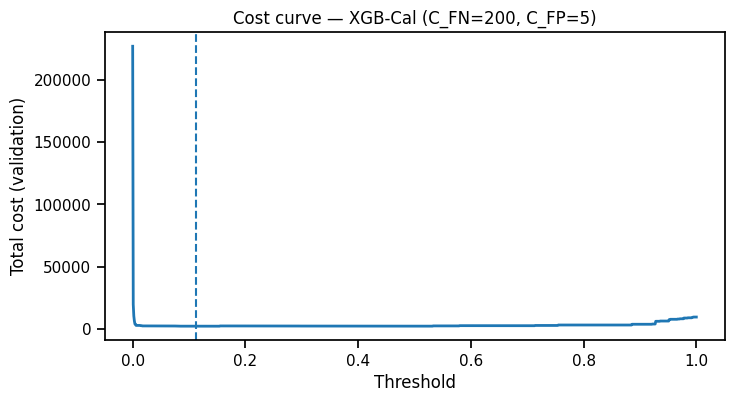

In [123]:
import matplotlib.pyplot as plt
ths = np.linspace(0.0, 1.0, 1001)
curves = []
for t in ths:
    c, *_ = biz_total_cost(y_val.values, val_xgb_cal, t, C_FN, C_FP)
    curves.append(c)

best_thr = float(biz_best_threshold(y_val.values, val_xgb_cal, C_FN, C_FP))
plt.figure(figsize=(8,4))
plt.plot(ths, curves, lw=2)
plt.axvline(best_thr, ls="--")
plt.xlabel("Threshold"); plt.ylabel("Total cost (validation)")
plt.title(f"Cost curve — XGB-Cal (C_FN={C_FN:.0f}, C_FP={C_FP:.0f})")
plt.show()

In [124]:
from sklearn.metrics import confusion_matrix

for name, (_, p_test) in models.items():
    thr = float(biz_base.loc[biz_base["model"]==name, "threshold"].iloc[0])
    cm = confusion_matrix(y_test.values, (p_test >= thr).astype(int), labels=[0,1])
    print(f"\n{name} — Confusion @ τ={thr:.4f} (rows=true [0,1], cols=pred [0,1])\n{cm}")


Logistic — Confusion @ τ=0.9065 (rows=true [0,1], cols=pred [0,1])
[[56400   272]
 [   11    63]]

RF-Cal — Confusion @ τ=0.0090 (rows=true [0,1], cols=pred [0,1])
[[56630    42]
 [   13    61]]

XGB-Cal — Confusion @ τ=0.1125 (rows=true [0,1], cols=pred [0,1])
[[56585    87]
 [   15    59]]


# Overlay PR Curves

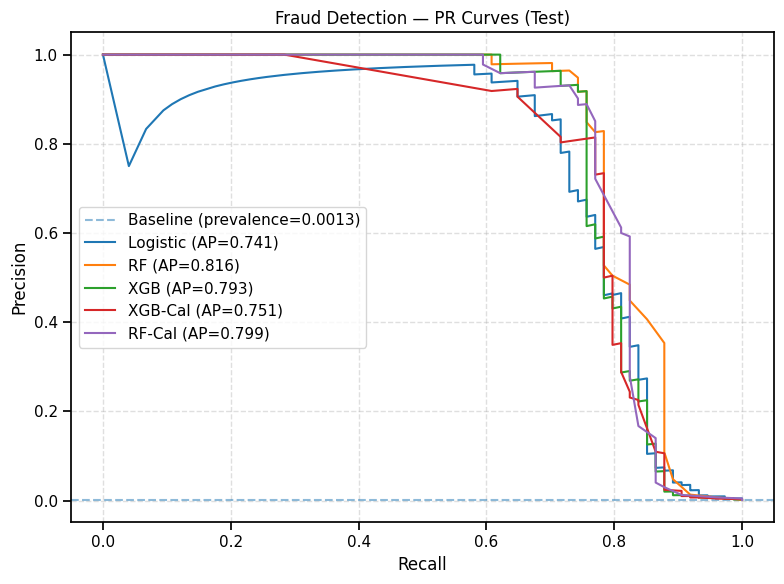

In [125]:

def plot_pr_overlay(y_true, preds_dict, title="PR Curves — Overlay"):
    plt.figure(figsize=(8,6))
    base = y_true.mean()
    plt.axhline(base, ls="--", alpha=0.5, label=f"Baseline (prevalence={base:.4f})")

    for name, y_prob in preds_dict.items():
        ps, rs, _ = precision_recall_curve(y_true, y_prob)
        ap = average_precision_score(y_true, y_prob)
        plt.plot(rs, ps, label=f"{name} (AP={ap:.3f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.grid(True, ls="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

preds_test = {
    "Logistic":        test_log_proba,
    "RF":              test_rf_proba,
    "XGB":             test_xgb_proba,
    "XGB-Cal":         test_xgb_cal,
        "RF-Cal":          test_rf_cal,
}
plot_pr_overlay(y_test, preds_test, title="Fraud Detection — PR Curves (Test)")


# Reliability Overlay for key models

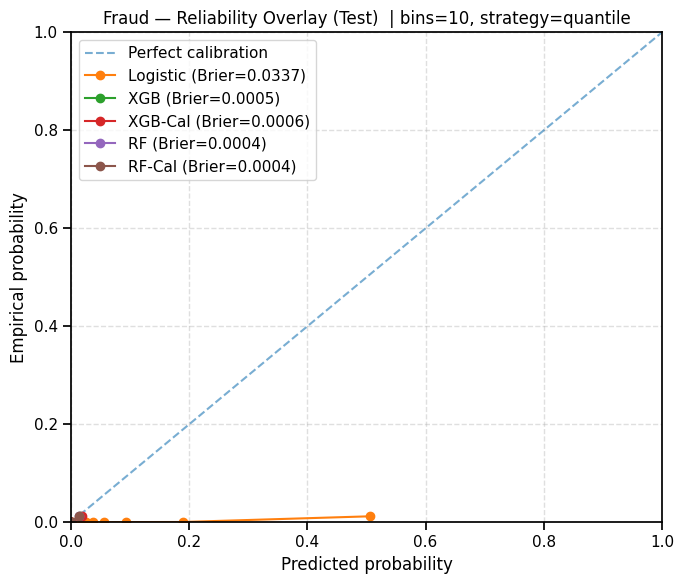

In [126]:
def reliability_overlay(y_true, preds_dict, bins=10, strategy="quantile",
                        title="Reliability (Calibration) — Overlay"):
    plt.figure(figsize=(7,6))
    plt.plot([0,1],[0,1], "--", alpha=0.6, label="Perfect calibration")

    for name, y_prob in preds_dict.items():
        prob_true, prob_pred = calibration_curve(y_true, y_prob,
                                                n_bins=bins, strategy=strategy)
        brier = brier_score_loss(y_true, y_prob)
        plt.plot(prob_pred, prob_true, marker="o", label=f"{name} (Brier={brier:.4f})")

    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel("Predicted probability")
    plt.ylabel("Empirical probability")
    plt.title(title + f"  | bins={bins}, strategy={strategy}")
    plt.grid(True, ls="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

reliab_models = {
    "Logistic": test_log_proba,
    "XGB":      test_xgb_proba,
    "XGB-Cal":  test_xgb_cal,
    "RF":       test_rf_proba,
    "RF-Cal":   test_rf_cal,
}
reliability_overlay(y_test, reliab_models, bins=10, strategy="quantile",
                    title="Fraud — Reliability Overlay (Test)")


# Threshold Tuning XGB-Cal

[VAL|XGB-Cal] Thr@P≥90%: thr=0.886, P=0.921, R=0.673
[VAL|XGB-Cal] Thr@Min-Cost: thr=0.528, Cost=2820.00

===== XGB-Cal — TEST EVAL =====
XGB-Cal@Test (Thr@P≥90%): {'threshold': 0.885699450969696, 'precision': np.float64(0.9230769230769231), 'recall': np.float64(0.6486486486486487), 'f1': np.float64(0.7619047619047619), 'roc_auc': np.float64(0.9741995665908709), 'auprc': np.float64(0.7512582520688527), 'brier': np.float64(0.0006061397696107926), 'tp': 48, 'fp': 4, 'fn': 26, 'tn': 56668}
XGB-Cal@Test (Thr@Min-Cost): {'threshold': 0.528, 'precision': np.float64(0.7307692307692307), 'recall': np.float64(0.7702702702702703), 'f1': np.float64(0.75), 'roc_auc': np.float64(0.9741995665908709), 'auprc': np.float64(0.7512582520688527), 'brier': np.float64(0.0006061397696107926), 'tp': 57, 'fp': 21, 'fn': 17, 'tn': 56651}
[TEST|XGB-Cal] Realized Cost @ P≥90% thr (0.886): 5280.00
[TEST|XGB-Cal] Realized Cost @ Min-Cost thr (0.528): 3820.00


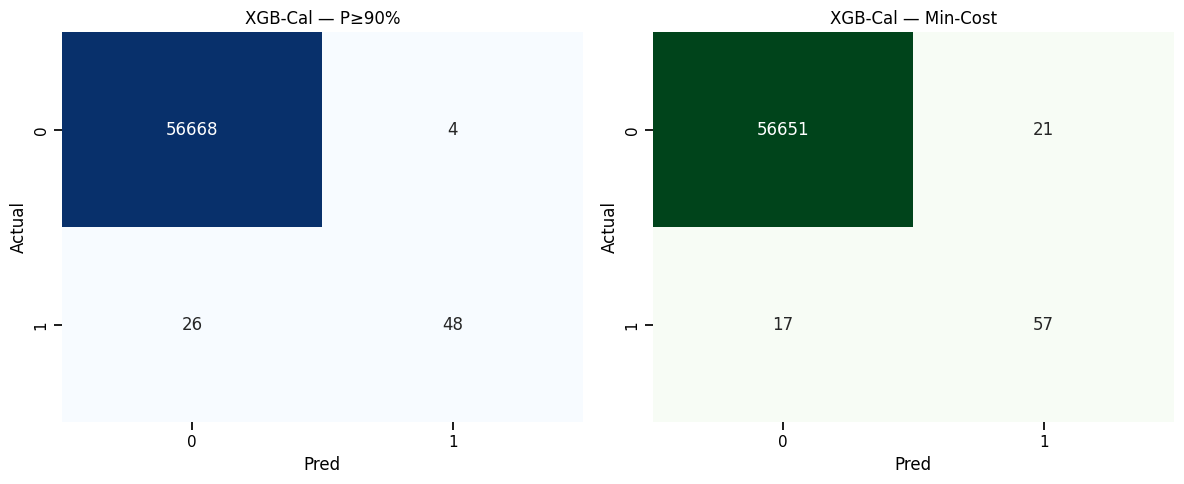

In [127]:
thr_p90_xgb, p_val_xgb, r_val_xgb = thr_for_precision(y_val, val_xgb_cal, target_p=0.90)
thr_cost_xgb, best_cost_val_xgb = thr_min_cost(y_val,  val_xgb_cal, cost_fp=COST_FP, cost_fn=COST_FN)

print(f"[VAL|XGB-Cal] Thr@P≥90%: thr={thr_p90_xgb:.3f}, P={p_val_xgb:.3f}, R={r_val_xgb:.3f}")
print(f"[VAL|XGB-Cal] Thr@Min-Cost: thr={thr_cost_xgb:.3f}, Cost={best_cost_val_xgb:.2f}")

eval_xgb_p90  = evaluate_block(y_test, test_xgb_cal, thr_p90_xgb)
eval_xgb_cost = evaluate_block(y_test, test_xgb_cal, thr_cost_xgb)
cm_xgb_p90  = confusion_matrix(y_test, (test_xgb_cal >= thr_p90_xgb ).astype(int))
cm_xgb_cost = confusion_matrix(y_test, (test_xgb_cal >= thr_cost_xgb).astype(int))

print("\n===== XGB-Cal — TEST EVAL =====")
print("XGB-Cal@Test (Thr@P≥90%):",  eval_xgb_p90)
print("XGB-Cal@Test (Thr@Min-Cost):", eval_xgb_cost)

cost_xgb_p90 = realized_cost(y_test, test_xgb_cal, thr_p90_xgb,  cost_fp=COST_FP, cost_fn=COST_FN)
cost_xgb_min = realized_cost(y_test, test_xgb_cal, thr_cost_xgb, cost_fp=COST_FP, cost_fn=COST_FN)
print(f"[TEST|XGB-Cal] Realized Cost @ P≥90% thr ({thr_p90_xgb:.3f}): {cost_xgb_p90:.2f}")
print(f"[TEST|XGB-Cal] Realized Cost @ Min-Cost thr ({thr_cost_xgb:.3f}): {cost_xgb_min:.2f}")

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(cm_xgb_p90,  annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('XGB-Cal — P≥90%');  axes[0].set_xlabel('Pred'); axes[0].set_ylabel('Actual')
sns.heatmap(cm_xgb_cost, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[1])
axes[1].set_title('XGB-Cal — Min-Cost'); axes[1].set_xlabel('Pred'); axes[1].set_ylabel('Actual')
plt.tight_layout(); plt.show()


# Threshold tuning RF-Cal



[VAL|RF-Cal] Thr@P≥90%: thr=0.683, P=0.949, R=0.712
[VAL|RF-Cal] Thr@Min-Cost: thr=0.329, Cost=2720.00

===== RF-Cal — TEST EVAL =====
RF-Cal@Test (Thr@P≥90%): {'threshold': 0.6833333333333332, 'precision': np.float64(0.9310344827586207), 'recall': np.float64(0.7297297297297297), 'f1': np.float64(0.8181818181818182), 'roc_auc': np.float64(0.9811344464877073), 'auprc': np.float64(0.7985448082041563), 'brier': np.float64(0.00042934674686147365), 'tp': 54, 'fp': 4, 'fn': 20, 'tn': 56668}
RF-Cal@Test (Thr@Min-Cost): {'threshold': 0.329, 'precision': np.float64(0.7702702702702703), 'recall': np.float64(0.7702702702702703), 'f1': np.float64(0.7702702702702703), 'roc_auc': np.float64(0.9811344464877073), 'auprc': np.float64(0.7985448082041563), 'brier': np.float64(0.00042934674686147365), 'tp': 57, 'fp': 17, 'fn': 17, 'tn': 56655}
[TEST|RF-Cal] Realized Cost @ P≥90% thr (0.683): 4080.00
[TEST|RF-Cal] Realized Cost @ Min-Cost thr (0.329): 3740.00


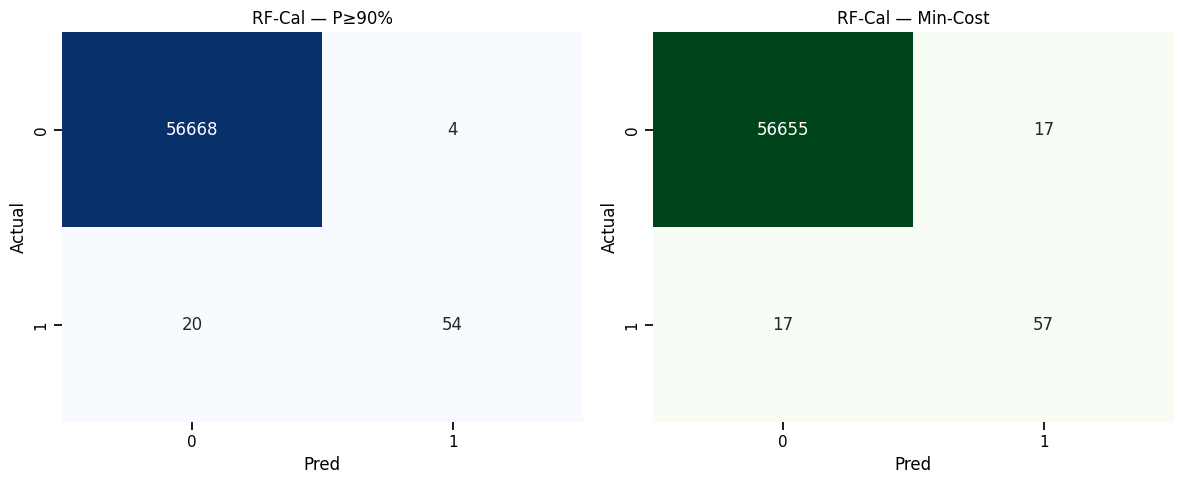

In [128]:
thr_p90_rf, p_val_rf, r_val_rf = thr_for_precision(y_val, val_rf_cal, target_p=0.90)
thr_cost_rf, best_cost_val_rf = thr_min_cost(y_val,  val_rf_cal, cost_fp=COST_FP, cost_fn=COST_FN)

print(f"\n[VAL|RF-Cal] Thr@P≥90%: thr={thr_p90_rf:.3f}, P={p_val_rf:.3f}, R={r_val_rf:.3f}")
print(f"[VAL|RF-Cal] Thr@Min-Cost: thr={thr_cost_rf:.3f}, Cost={best_cost_val_rf:.2f}")

eval_rf_p90  = evaluate_block(y_test, test_rf_cal, thr_p90_rf)
eval_rf_cost = evaluate_block(y_test, test_rf_cal, thr_cost_rf)
cm_rf_p90  = confusion_matrix(y_test, (test_rf_cal >= thr_p90_rf ).astype(int))
cm_rf_cost = confusion_matrix(y_test, (test_rf_cal >= thr_cost_rf).astype(int))

print("\n===== RF-Cal — TEST EVAL =====")
print("RF-Cal@Test (Thr@P≥90%):",  eval_rf_p90)
print("RF-Cal@Test (Thr@Min-Cost):", eval_rf_cost)

cost_rf_p90 = realized_cost(y_test, test_rf_cal, thr_p90_rf,  cost_fp=COST_FP, cost_fn=COST_FN)
cost_rf_min = realized_cost(y_test, test_rf_cal, thr_cost_rf, cost_fp=COST_FP, cost_fn=COST_FN)
print(f"[TEST|RF-Cal] Realized Cost @ P≥90% thr ({thr_p90_rf:.3f}): {cost_rf_p90:.2f}")
print(f"[TEST|RF-Cal] Realized Cost @ Min-Cost thr ({thr_cost_rf:.3f}): {cost_rf_min:.2f}")

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(cm_rf_p90,  annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('RF-Cal — P≥90%');  axes[0].set_xlabel('Pred'); axes[0].set_ylabel('Actual')
sns.heatmap(cm_rf_cost, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[1])
axes[1].set_title('RF-Cal — Min-Cost'); axes[1].set_xlabel('Pred'); axes[1].set_ylabel('Actual')
plt.tight_layout(); plt.show()


#  Cost & Alerts vs Threshold

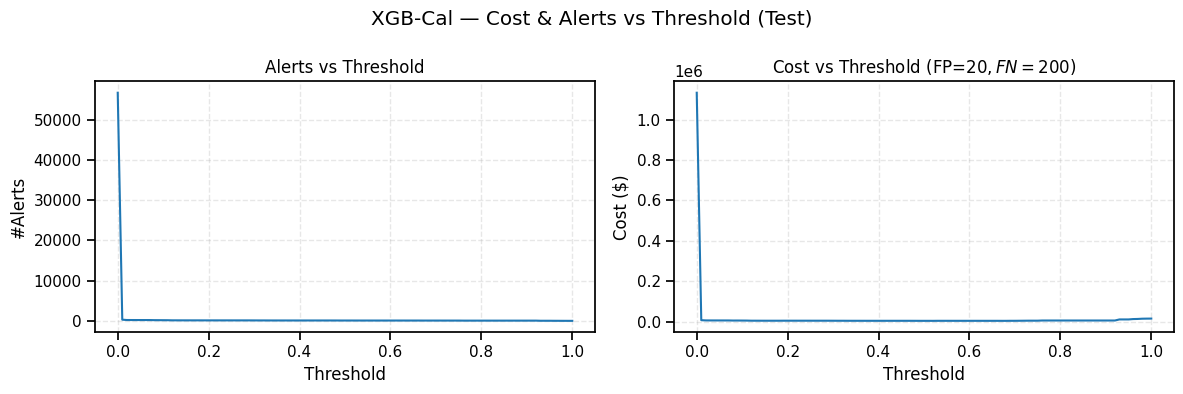

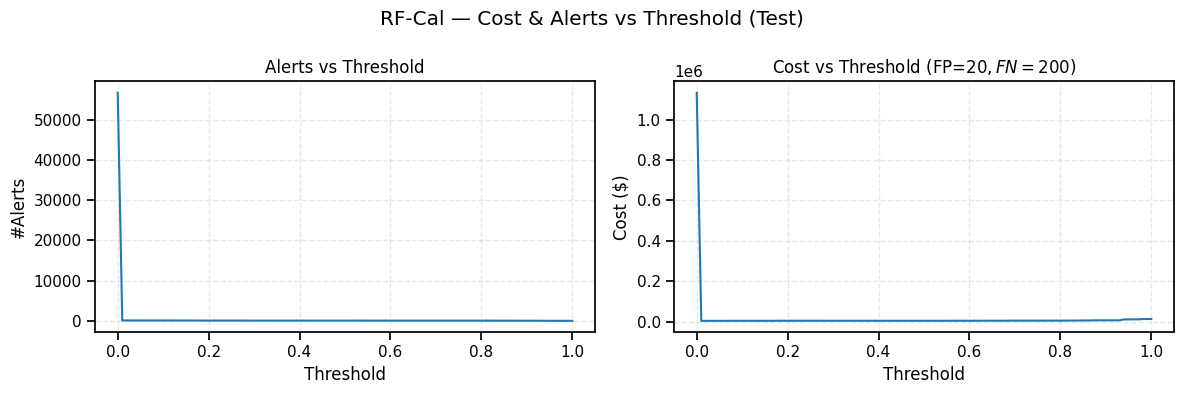

In [129]:
def plot_cost_and_alerts(y_true, y_prob, cost_fp=5.0, cost_fn=200.0, title="Cost & Alerts vs Threshold"):
    df_sweep = sweep_thresholds(y_true, y_prob, costs=(cost_fp, cost_fn))
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    # Alerts = tp + fp
    ax[0].plot(df_sweep["thr"], df_sweep["tp"] + df_sweep["fp"])
    ax[0].set_title("Alerts vs Threshold")
    ax[0].set_xlabel("Threshold"); ax[0].set_ylabel("#Alerts")
    ax[0].grid(True, ls="--", alpha=0.3)

    # Cost curve
    ax[1].plot(df_sweep["thr"], df_sweep["cost"])
    ax[1].set_title(f"Cost vs Threshold (FP=${cost_fp:.0f}, FN=${cost_fn:.0f})")
    ax[1].set_xlabel("Threshold"); ax[1].set_ylabel("Cost ($)")
    ax[1].grid(True, ls="--", alpha=0.3)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    return df_sweep

df_xgbcal_sweep = plot_cost_and_alerts(y_test, test_xgb_cal, cost_fp=COST_FP, cost_fn=COST_FN,
                                      title="XGB-Cal — Cost & Alerts vs Threshold (Test)")
df_rfcal_sweep  = plot_cost_and_alerts(y_test, test_rf_cal,  cost_fp=COST_FP, cost_fn=COST_FN,
                                      title="RF-Cal — Cost & Alerts vs Threshold (Test)")


## Calibrated Models — Side-by-Side

In [130]:
def summarise_model(name, y_true, y_prob, thr_p90, thr_cost):
    ap = average_precision_score(y_true, y_prob)
    roc = roc_auc_score(y_true, y_prob)
    brier = brier_score_loss(y_true, y_prob)
    ece = expected_calibration_error(y_true.values, y_prob, n_bins=15)
    cost_p90 = realized_cost(y_true, y_prob, thr_p90, COST_FP, COST_FN)
    cost_min = realized_cost(y_true, y_prob, thr_cost, COST_FP, COST_FN)
    ap_lo, ap_hi = bootstrap_ci(average_precision_score, y_true.values, y_prob)
    return {
        "Model": name, "AP(Test)": ap, "AP 95% CI": f"[{ap_lo:.3f}, {ap_hi:.3f}]",
        "ROC-AUC(Test)": roc, "Brier(Test)": brier, "ECE(15)": ece,
        "Thr@P90(val)": float(thr_p90), "Thr@MinCost(val)": float(thr_cost),
        "Cost@Test@P90": cost_p90, "Cost@Test@MinCost": cost_min,
    }

summary_df = pd.DataFrame([
    summarise_model("RF-Cal",  y_test, test_rf_cal,  thr_p90_rf,  thr_cost_rf),
    summarise_model("XGB-Cal", y_test, test_xgb_cal, thr_p90_xgb, thr_cost_xgb),
]).sort_values("AP(Test)", ascending=False)

display(summary_df.round(4))


,Model,AP(Test),AP 95% CI,ROC-AUC(Test),Brier(Test),ECE(15),Thr@P90(val),Thr@MinCost(val),Cost@Test@P90,Cost@Test@MinCost
0,RF-Cal,0.7985,"[0.710, 0.881]",0.9811,0.0004,0.0003,0.6833,0.329,4080.0,3740.0
1,XGB-Cal,0.7513,"[0.655, 0.845]",0.9742,0.0006,0.0007,0.8857,0.528,5280.0,3820.0


# Alerts and Fraud caught per 100k

In [131]:
def summarize_ops(y_true, y_prob, thr, name, cost_fp=COST_FP, cost_fn=COST_FN):
    yhat = (y_prob >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0,1]).ravel()
    N = len(y_true)
    alerts = tp + fp
    cost = fp*cost_fp + fn*cost_fn
    savings = tp*cost_fn - fp*cost_fp

    return {
        "Model": name,
        "Threshold": float(thr),
        "TP": int(tp), "FP": int(fp), "FN": int(fn), "TN": int(tn),
        "Precision": precision_score(y_true, yhat, zero_division=0),
        "Recall": recall_score(y_true, yhat),
        "F1": f1_score(y_true, yhat, zero_division=0),
        "Alerts": int(alerts),
        "Alerts/100k":  (alerts / N) * 100000,
        "FraudCaught/100k": (tp / N) * 100000,
        "Cost($)": cost,
        "Cost/100k($)": (cost / N) * 100000,
        "NetSavings($)": savings
    }

ops_rows = []
ops_rows.append(summarize_ops(y_test, test_rf_cal,  thr_p90_rf,  "RF-Cal @P90"))
ops_rows.append(summarize_ops(y_test, test_rf_cal,  thr_cost_rf, "RF-Cal @MinCost"))
ops_rows.append(summarize_ops(y_test, test_xgb_cal, thr_p90_xgb, "XGB-Cal @P90"))
ops_rows.append(summarize_ops(y_test, test_xgb_cal, thr_cost_xgb,"XGB-Cal @MinCost"))
ops_df = pd.DataFrame(ops_rows)

prevalence = y_test.mean()
ops_df["Alerts%"] = (ops_df["Alerts/100k"] / 100000) * 100
ops_df["PrecisionLift(x)"] = ops_df["Precision"] / max(1e-9, prevalence)

cols_order = [
    "Model","Threshold",
    "TP","FP","FN","TN",
    "Precision","Recall","F1",
    "Alerts","Alerts%","Alerts/100k","FraudCaught/100k",
    "Cost($)","Cost/100k($)","NetSavings($)","PrecisionLift(x)"
]
ops_df = ops_df[cols_order].round(4)
display(ops_df)

cx_cost_rf  = realized_cost(y_test, test_rf_cal,  thr_p90_rf,  COST_FP, COST_FN)
cx_cost_xgb = realized_cost(y_test, test_xgb_cal, thr_p90_xgb, COST_FP, COST_FN)
cx_brier_rf, cx_brier_xgb = brier_score_loss(y_test, test_rf_cal), brier_score_loss(y_test, test_xgb_cal)

cx_best_by_cost  = "RF-Cal"  if cx_cost_rf  <= cx_cost_xgb  else "XGB-Cal"
cx_best_by_brier = "RF-Cal"  if cx_brier_rf <= cx_brier_xgb else "XGB-Cal"

print(f"[CX-first @P90] Lower Cost: {cx_best_by_cost}  | Better Brier: {cx_best_by_brier}")

min_cost_rf  = realized_cost(y_test, test_rf_cal,  thr_cost_rf,  COST_FP, COST_FN)
min_cost_xgb = realized_cost(y_test, test_xgb_cal, thr_cost_xgb, COST_FP, COST_FN)
best_cost_model = "RF-Cal" if min_cost_rf <= min_cost_xgb else "XGB-Cal"
print(f"[Cost-first @MinCost] Lower Cost: {best_cost_model}")

print(f"Prevalence(Test) = {prevalence:.4%} | Baseline Precision = {prevalence:.4%}")


,Model,Threshold,TP,FP,FN,TN,Precision,Recall,F1,Alerts,Alerts%,Alerts/100k,FraudCaught/100k,Cost($),Cost/100k($),NetSavings($),PrecisionLift(x)
0,RF-Cal @P90,0.6833,54,4,20,56668,0.9310,0.7297,0.8182,58,0.1022,102.2098,95.1609,4080.0,7189.9341,10720.0,713.9525
1,RF-Cal @MinCost,0.3290,57,17,17,56655,0.7703,0.7703,0.7703,74,0.1304,130.4057,100.4476,3740.0,6590.7729,11060.0,590.6724
2,XGB-Cal @P90,0.8857,48,4,26,56668,0.9231,0.6486,0.7619,52,0.0916,91.6364,84.5875,5280.0,9304.6206,9520.0,707.8503
3,XGB-Cal @MinCost,0.5280,57,21,17,56651,0.7308,0.7703,0.7500,78,0.1375,137.4546,100.4476,3820.0,6731.7520,10980.0,560.3815


[CX-first @P90] Lower Cost: RF-Cal  | Better Brier: RF-Cal
[Cost-first @MinCost] Lower Cost: RF-Cal
Prevalence(Test) = 0.1304% | Baseline Precision = 0.1304%


# Sampling comparison

In [132]:
samplers = {
    "None": None,
    "Under": RandomUnderSampler(random_state=SEED),
    "SMOTE": SMOTE(random_state=SEED),
    "SMOTE+Tomek": SMOTETomek(random_state=SEED),
}

sample_results = []

for name, sampler in samplers.items():
    steps = []
    if sampler is not None:
        steps.append(("sampler", sampler))
    steps.extend([
        ("scaler", StandardScaler(with_mean=True)),
        ("clf", LogisticRegression(max_iter=2000, class_weight=None, random_state=SEED))
    ])

    pipe = ImbPipeline(steps=steps)
    pipe.fit(X_train, y_train)

    val_prob  = pipe.predict_proba(X_val)[:, 1]
    test_prob = pipe.predict_proba(X_test)[:, 1]

    thr90, _, _ = thr_for_precision(y_val, val_prob, 0.90)

    sample_results.append({
        "sampler": name,
        "VAL_AUPRC":  average_precision_score(y_val,  val_prob),
        "TEST_AUPRC": average_precision_score(y_test, test_prob),
        "TEST_ROC_AUC": roc_auc_score(y_test, test_prob),
        "TEST_Recall@P90": evaluate_block(y_test, test_prob, thr90)["recall"],
    })

sample_df = pd.DataFrame(sample_results).sort_values("TEST_AUPRC", ascending=False)
display(sample_df.round(4))


,sampler,VAL_AUPRC,TEST_AUPRC,TEST_ROC_AUC,TEST_Recall@P90
3,SMOTE+Tomek,0.7709,0.7711,0.9655,0.7297
2,SMOTE,0.7709,0.7711,0.9655,0.7297
0,None,0.6706,0.7072,0.9743,0.4595
1,Under,0.2247,0.3882,0.9850,1.0000


# Executive Summary — Results & Insights

- **Evaluation setup:** time-ordered split, isotonic calibration (TimeSeriesSplit cv=3), decisions at **Precision ≥90%** and **Min-Cost** (FN=$200, FP=$20).  
- **Primary yardstick:** **AUPRC (AP)** for minority-class performance; **Brier + ECE** to judge probability reliability.

## Headline Results (Test)

Below are the calibrated models evaluated on the held-out test set.  
The table is generated programmatically from `summary_df`:



In [133]:
display(summary_df.round(4))


,Model,AP(Test),AP 95% CI,ROC-AUC(Test),Brier(Test),ECE(15),Thr@P90(val),Thr@MinCost(val),Cost@Test@P90,Cost@Test@MinCost
0,RF-Cal,0.7985,"[0.710, 0.881]",0.9811,0.0004,0.0003,0.6833,0.329,4080.0,3740.0
1,XGB-Cal,0.7513,"[0.655, 0.845]",0.9742,0.0006,0.0007,0.8857,0.528,5280.0,3820.0
